In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout,UpSampling2D, Dense, MaxPooling2D, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')
display(csv_data.head()), display(csv_data.shape)
train_path = 'unseen-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'unseen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(train_images)+len(val_images)

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


(13570, 16)

13794

In [5]:
# len(list(set(list(x[:4] for x in images['image'])))), len(list(set(list(x[:4] for x in csv_data['ImageId']))))

In [6]:
dataset_columns = csv_data.columns
csv_data['imagename'] = csv_data['imagename'].astype('str')
display(csv_data.head(20))
csv_data.shape

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2
5,1316a_num2.png,2,2,1,1,2,2,3,1,1,2,2,2,3,2,2
6,1503c_num2.png,2,1,2,2,2,2,2,1,1,3,2,2,3,2,2
7,0113c_num1.png,2,3,2,2,2,1,2,1,1,1,2,2,2,2,2
8,0221a_num6.png,2,2,2,2,2,1,1,1,1,4,1,2,3,1,2
9,0068a_num4.png,1,1,2,2,2,2,1,1,1,2,2,2,2,2,2


(13570, 16)

In [7]:
# train_csv_data =  csv_data[:700]
# val_csv_data =  csv_data[700:]
# train_csv_data.shape, val_csv_data.shape

In [8]:
f = []
for col in dataset_columns[1:]:
    f.append(csv_data[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [9]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.load_weights('weights/simple_ae_maxpool_Unseen_weights_v1.h5')

In [10]:
encoder = Model(autoencoder.input,autoencoder.get_layer('encoded').output)
encoder.summary()
# for layer in encoder.layers:
#     layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [11]:

# # model = Sequential()
# input_layer = Input((64,64,1))
# model = BatchNormalization()(input_layer)

# model = Conv2D(activation='relu',filters=32, kernel_size=(32,32), padding='same')(model)
# model = Conv2D(activation='relu',filters=64, kernel_size=(32,32), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(16,16), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(16,16), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(8,8), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(8,8), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)
# # model = Flatten()(model)

# dense_layer = Dense(512, activation='relu')(model)
# dense_layer = Dropout(0.5)(dense_layer)
dense_layer = encoder.get_layer('encoded').output
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(Flatten(name='flatten_'+str(i))((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

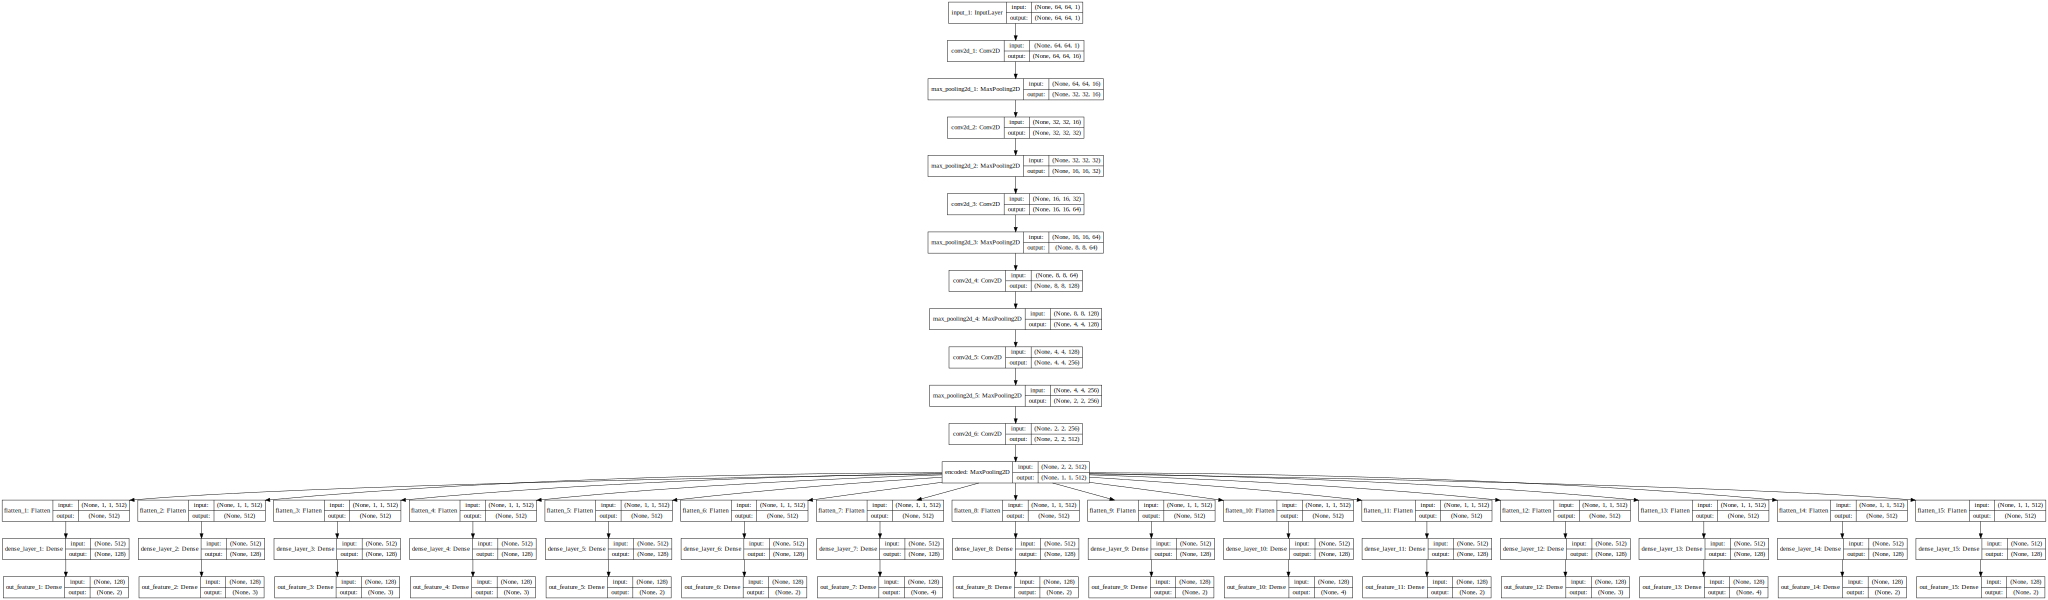

In [12]:
SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(csv_data[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

In [14]:
# df_data[df_data['f8']==2]

In [15]:
# im = images[images['image'].str.match('1229b')]
# im.iloc[0]['image']

In [16]:

# stop_at = 20
# identitycounter = 1
# unique_writers = list(set(list(x[:4] for x in df_data['ImageId'])))
# for writer in unique_writers:
#     print(identitycounter*100/stop_at, end='\r')
#     writer_samples = list(images[images['image'].str.match(writer)]['image'])
# #     print('lne',len(writer_samples))
#     f,ax = plt.subplots(1,len(writer_samples))
#     f.subplots_adjust(hspace = .5, wspace=.15)
#     f.set_size_inches(15,15)
#     imgcounter = 0
#     for sample in writer_samples:
#         imagepath = os.path.join(image_path,sample)
#         raw_img = cv2.imread(imagepath)
#         if len(writer_samples)>1:
#             ax[imgcounter].imshow(raw_img)
#             ax[imgcounter].set_title(writer+'\n'+sample)
#         else:
#             ax.imshow(raw_img)
#             ax.set_title(writer+'\n'+sample)
# #         ax[imgcounter].axis('off')
#         imgcounter+=1
#         if imgcounter == stop_at:
#             break
#     imgcounter=0
#     identitycounter += 1
#     if identitycounter == stop_at+1:
#         break

In [17]:
# csv_data[csv_data['ImageId'].str.match('1302c')]

In [18]:

def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
#         counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        
        writer_index = np.random.randint(0,len(list_of_writers))
        
#         for writer_index in writer_indexes:
#             class_vectors = []
#             features = None
        imagename = list_of_writers[writer_index]
#             print('-->',csv_data['imagename'][0],imagename)
#             display(csv_data[csv_data['imagename']==imagename].values[0][1:])
        features = csv_data[csv_data['imagename']==imagename].values
        if len(features)==0:
#             print('no features', imagename)
            continue
        features = features[0][1:]-1
#             print(features)
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]


        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)
#         print(imagename)
        counter+=1
#         print('counter:', counter, end='\r')
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
#                 print(feature_list[1])
                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    

In [19]:

batch_size = 64

tg = datagen(batch_size,image_path=train_path,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)


In [20]:
# images
inputs,o = next(tg)
print(inputs.shape)
for op in o:
    print((np.argmax(op, axis=1)+1)[0])
#     print('------')
# feature_list

(64, 64, 64, 1)
2
2
1
1
2
2
1
1
1
3
1
3
1
1
1


In [21]:
csv_data[csv_data['imagename']=='0066c_num3.png'].values[0][1:]

array([2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1], dtype=object)

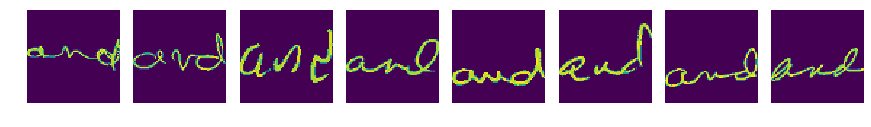

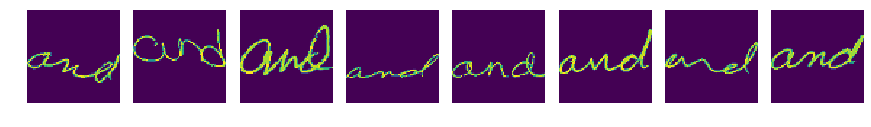

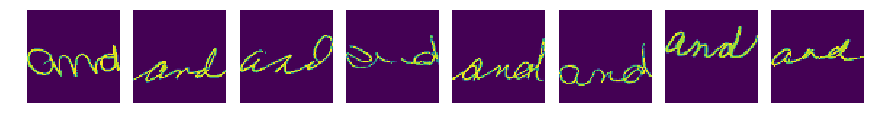

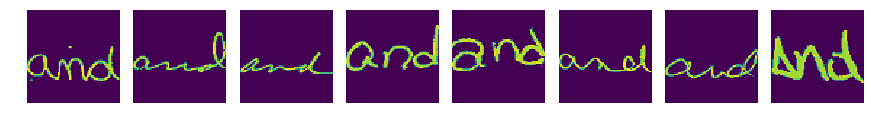

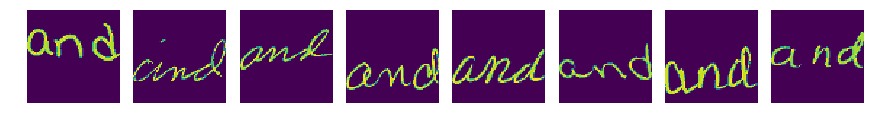

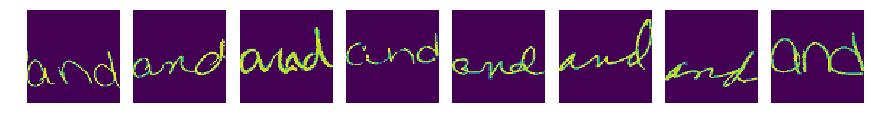

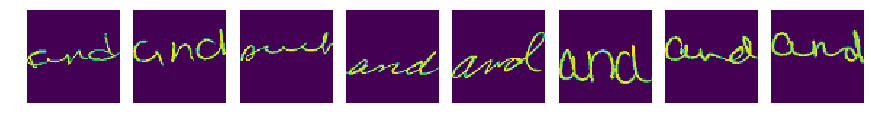

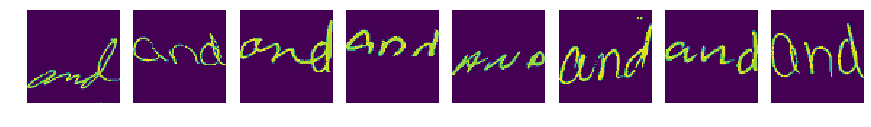

In [22]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [23]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0
# lossWeights["out_feature_1"] = 10.0
# lossWeights["out_feature_2"] = 8.0
# lossWeights["out_feature_3"] = 0.1
# lossWeights["out_feature_4"] = 8.0
# lossWeights["out_feature_5"] = 1.0
# lossWeights["out_feature_6"] = 5.0
# lossWeights["out_feature_7"] = 5.0
# lossWeights["out_feature_8"] = 10.0


In [24]:
mc = ModelCheckpoint(filepath='weights/15-Multitask-TrainableEncoder-unseen_v2.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [25]:
EPOCHS = 50000
INIT_LR = 0.0001
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = Adadelta(lr=INIT_LR, decay=1e-04)

# feat_extractor.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])


human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [26]:
# human_features.load_weights('human_features_weights_v3.h5')
# inputs,o = next(vg)
# for i in range(64):
#     print(i)
#     f_probs = human_features.predict(np.expand_dims(inputs[i],0))
# #     print(f_probs)
#     for prob in f_probs:
#         print(np.argmax(prob),end=',')
#     print('++++++++++++')
# human_features.load_weights('15_human_features_weights_unseen_v1.h5')

In [27]:
human_features.load_weights('weights/15-Multitask-TrainableEncoder-unseen_v1.h5')
hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/50000

Epoch 00001: val_loss improved from inf to 9.40073, saving model to weights/15-Multitask-TrainableEncoder-unseen_v2.h5
Epoch 2/50000

Epoch 00002: val_loss improved from 9.40073 to 9.34846, saving model to weights/15-Multitask-TrainableEncoder-unseen_v2.h5
Epoch 3/50000

Epoch 00003: val_loss did not improve from 9.34846
Epoch 4/50000

Epoch 00004: val_loss did not improve from 9.34846
Epoch 5/50000

Epoch 00005: val_loss did not improve from 9.34846
Epoch 6/50000

Epoch 00006: val_loss did not improve from 9.34846
Epoch 7/50000

Epoch 00007: val_loss improved from 9.34846 to 9.18234, saving model to weights/15-Multitask-TrainableEncoder-unseen_v2.h5
Epoch 8/50000

Epoch 00008: val_loss did not improve from 9.18234
Epoch 9/50000

Epoch 00009: val_loss improved from 9.18234 to 9.06478, saving model to weights/15-Multitask-TrainableEncoder-unseen_v2.h5
Epoch 10/50000

Epoch 00010: val_loss did not improve from 9.06478
Epoch 11/50000

Epoch 00011: val_loss did not improve f


Epoch 00111: val_loss did not improve from 8.12610
Epoch 112/50000

Epoch 00112: val_loss did not improve from 8.12610
Epoch 113/50000

Epoch 00113: val_loss did not improve from 8.12610
Epoch 114/50000

Epoch 00114: val_loss did not improve from 8.12610
Epoch 115/50000

Epoch 00115: val_loss did not improve from 8.12610
Epoch 116/50000

Epoch 00116: val_loss did not improve from 8.12610
Epoch 117/50000

Epoch 00117: val_loss did not improve from 8.12610
Epoch 118/50000

Epoch 00118: val_loss did not improve from 8.12610
Epoch 119/50000

Epoch 00119: val_loss did not improve from 8.12610
Epoch 120/50000

Epoch 00120: val_loss did not improve from 8.12610
Epoch 121/50000

Epoch 00121: val_loss did not improve from 8.12610
Epoch 122/50000

Epoch 00122: val_loss did not improve from 8.12610
Epoch 123/50000

Epoch 00123: val_loss did not improve from 8.12610
Epoch 124/50000

Epoch 00124: val_loss did not improve from 8.12610
Epoch 125/50000

Epoch 00125: val_loss did not improve from 8.12

Epoch 230/50000

Epoch 00230: val_loss did not improve from 7.65994
Epoch 231/50000

Epoch 00231: val_loss did not improve from 7.65994
Epoch 232/50000

Epoch 00232: val_loss did not improve from 7.65994
Epoch 233/50000

Epoch 00233: val_loss did not improve from 7.65994
Epoch 234/50000

Epoch 00234: val_loss did not improve from 7.65994
Epoch 235/50000

Epoch 00235: val_loss did not improve from 7.65994
Epoch 236/50000

Epoch 00236: val_loss did not improve from 7.65994
Epoch 237/50000

Epoch 00237: val_loss did not improve from 7.65994
Epoch 238/50000

Epoch 00238: val_loss did not improve from 7.65994
Epoch 239/50000

Epoch 00239: val_loss did not improve from 7.65994
Epoch 240/50000

Epoch 00240: val_loss did not improve from 7.65994
Epoch 241/50000

Epoch 00241: val_loss did not improve from 7.65994
Epoch 242/50000

Epoch 00242: val_loss did not improve from 7.65994
Epoch 243/50000

Epoch 00243: val_loss did not improve from 7.65994
Epoch 244/50000

Epoch 00244: val_loss did not i


Epoch 00349: val_loss did not improve from 7.61241
Epoch 350/50000

Epoch 00350: val_loss did not improve from 7.61241
Epoch 351/50000

Epoch 00351: val_loss did not improve from 7.61241
Epoch 352/50000

Epoch 00352: val_loss did not improve from 7.61241
Epoch 353/50000

Epoch 00353: val_loss improved from 7.61241 to 7.48816, saving model to weights/15-Multitask-TrainableEncoder-unseen_v2.h5
Epoch 354/50000

Epoch 00354: val_loss did not improve from 7.48816
Epoch 355/50000

Epoch 00355: val_loss did not improve from 7.48816
Epoch 356/50000

Epoch 00356: val_loss did not improve from 7.48816
Epoch 357/50000

Epoch 00357: val_loss did not improve from 7.48816
Epoch 358/50000

Epoch 00358: val_loss did not improve from 7.48816
Epoch 359/50000

Epoch 00359: val_loss did not improve from 7.48816
Epoch 360/50000

Epoch 00360: val_loss did not improve from 7.48816
Epoch 361/50000

Epoch 00361: val_loss did not improve from 7.48816
Epoch 362/50000

Epoch 00362: val_loss did not improve from 


Epoch 00468: val_loss did not improve from 7.17126
Epoch 469/50000

Epoch 00469: val_loss did not improve from 7.17126
Epoch 470/50000

Epoch 00470: val_loss did not improve from 7.17126
Epoch 471/50000

Epoch 00471: val_loss did not improve from 7.17126
Epoch 472/50000

Epoch 00472: val_loss did not improve from 7.17126
Epoch 473/50000

Epoch 00473: val_loss did not improve from 7.17126
Epoch 474/50000

Epoch 00474: val_loss did not improve from 7.17126
Epoch 475/50000

Epoch 00475: val_loss did not improve from 7.17126
Epoch 476/50000

Epoch 00476: val_loss did not improve from 7.17126
Epoch 477/50000

Epoch 00477: val_loss did not improve from 7.17126
Epoch 478/50000

Epoch 00478: val_loss did not improve from 7.17126
Epoch 479/50000

Epoch 00479: val_loss did not improve from 7.17126
Epoch 480/50000

Epoch 00480: val_loss did not improve from 7.17126
Epoch 481/50000

Epoch 00481: val_loss did not improve from 7.17126
Epoch 482/50000

Epoch 00482: val_loss did not improve from 7.17


Epoch 00589: val_loss did not improve from 7.17126
Epoch 590/50000

Epoch 00590: val_loss did not improve from 7.17126
Epoch 591/50000

Epoch 00591: val_loss did not improve from 7.17126
Epoch 592/50000

Epoch 00592: val_loss did not improve from 7.17126
Epoch 593/50000

Epoch 00593: val_loss did not improve from 7.17126
Epoch 594/50000

Epoch 00594: val_loss did not improve from 7.17126
Epoch 595/50000

Epoch 00595: val_loss did not improve from 7.17126
Epoch 596/50000

Epoch 00596: val_loss did not improve from 7.17126
Epoch 597/50000

Epoch 00597: val_loss did not improve from 7.17126
Epoch 598/50000

Epoch 00598: val_loss did not improve from 7.17126
Epoch 599/50000

Epoch 00599: val_loss did not improve from 7.17126
Epoch 600/50000

Epoch 00600: val_loss did not improve from 7.17126
Epoch 601/50000

Epoch 00601: val_loss did not improve from 7.17126
Epoch 602/50000

Epoch 00602: val_loss did not improve from 7.17126
Epoch 603/50000

Epoch 00603: val_loss did not improve from 7.17


Epoch 00709: val_loss did not improve from 7.03063
Epoch 710/50000

Epoch 00710: val_loss did not improve from 7.03063
Epoch 711/50000

Epoch 00711: val_loss did not improve from 7.03063
Epoch 712/50000

Epoch 00712: val_loss did not improve from 7.03063
Epoch 713/50000

Epoch 00713: val_loss did not improve from 7.03063
Epoch 714/50000

Epoch 00714: val_loss did not improve from 7.03063
Epoch 715/50000

Epoch 00715: val_loss did not improve from 7.03063
Epoch 716/50000

Epoch 00716: val_loss did not improve from 7.03063
Epoch 717/50000

Epoch 00717: val_loss did not improve from 7.03063
Epoch 718/50000

Epoch 00718: val_loss did not improve from 7.03063
Epoch 719/50000

Epoch 00719: val_loss did not improve from 7.03063
Epoch 720/50000

Epoch 00720: val_loss did not improve from 7.03063
Epoch 721/50000

Epoch 00721: val_loss did not improve from 7.03063
Epoch 722/50000

Epoch 00722: val_loss did not improve from 7.03063
Epoch 723/50000

Epoch 00723: val_loss did not improve from 7.03


Epoch 00830: val_loss did not improve from 7.03063
Epoch 831/50000

Epoch 00831: val_loss did not improve from 7.03063
Epoch 832/50000

Epoch 00832: val_loss did not improve from 7.03063
Epoch 833/50000

Epoch 00833: val_loss did not improve from 7.03063
Epoch 834/50000

Epoch 00834: val_loss did not improve from 7.03063
Epoch 835/50000

Epoch 00835: val_loss did not improve from 7.03063
Epoch 836/50000

Epoch 00836: val_loss did not improve from 7.03063
Epoch 837/50000

Epoch 00837: val_loss did not improve from 7.03063
Epoch 838/50000

Epoch 00838: val_loss did not improve from 7.03063
Epoch 839/50000

Epoch 00839: val_loss did not improve from 7.03063
Epoch 840/50000

Epoch 00840: val_loss did not improve from 7.03063
Epoch 841/50000

Epoch 00841: val_loss did not improve from 7.03063
Epoch 842/50000

Epoch 00842: val_loss did not improve from 7.03063
Epoch 843/50000

Epoch 00843: val_loss did not improve from 7.03063
Epoch 844/50000

Epoch 00844: val_loss did not improve from 7.03


Epoch 00950: val_loss did not improve from 6.82769
Epoch 951/50000

Epoch 00951: val_loss did not improve from 6.82769
Epoch 952/50000

Epoch 00952: val_loss did not improve from 6.82769
Epoch 953/50000

Epoch 00953: val_loss did not improve from 6.82769
Epoch 954/50000

Epoch 00954: val_loss did not improve from 6.82769
Epoch 955/50000

Epoch 00955: val_loss did not improve from 6.82769
Epoch 956/50000

Epoch 00956: val_loss did not improve from 6.82769
Epoch 957/50000

Epoch 00957: val_loss did not improve from 6.82769
Epoch 958/50000

Epoch 00958: val_loss did not improve from 6.82769
Epoch 959/50000

Epoch 00959: val_loss did not improve from 6.82769
Epoch 960/50000

Epoch 00960: val_loss did not improve from 6.82769
Epoch 961/50000

Epoch 00961: val_loss did not improve from 6.82769
Epoch 962/50000

Epoch 00962: val_loss did not improve from 6.82769
Epoch 963/50000

Epoch 00963: val_loss did not improve from 6.82769
Epoch 964/50000

Epoch 00964: val_loss did not improve from 6.82


Epoch 01069: val_loss did not improve from 6.62241
Epoch 1070/50000

Epoch 01070: val_loss did not improve from 6.62241
Epoch 1071/50000

Epoch 01071: val_loss did not improve from 6.62241
Epoch 1072/50000

Epoch 01072: val_loss did not improve from 6.62241
Epoch 1073/50000

Epoch 01073: val_loss did not improve from 6.62241
Epoch 1074/50000

Epoch 01074: val_loss did not improve from 6.62241
Epoch 1075/50000

Epoch 01075: val_loss did not improve from 6.62241
Epoch 1076/50000

Epoch 01076: val_loss did not improve from 6.62241
Epoch 1077/50000

Epoch 01077: val_loss did not improve from 6.62241
Epoch 1078/50000

Epoch 01078: val_loss did not improve from 6.62241
Epoch 1079/50000

Epoch 01079: val_loss did not improve from 6.62241
Epoch 1080/50000

Epoch 01080: val_loss did not improve from 6.62241
Epoch 1081/50000

Epoch 01081: val_loss did not improve from 6.62241
Epoch 1082/50000

Epoch 01082: val_loss did not improve from 6.62241
Epoch 1083/50000

Epoch 01083: val_loss did not imp


Epoch 01188: val_loss did not improve from 6.62241
Epoch 1189/50000

Epoch 01189: val_loss did not improve from 6.62241
Epoch 1190/50000

Epoch 01190: val_loss did not improve from 6.62241
Epoch 1191/50000

Epoch 01191: val_loss did not improve from 6.62241
Epoch 1192/50000

Epoch 01192: val_loss did not improve from 6.62241
Epoch 1193/50000

Epoch 01193: val_loss did not improve from 6.62241
Epoch 1194/50000

Epoch 01194: val_loss did not improve from 6.62241
Epoch 1195/50000

Epoch 01195: val_loss did not improve from 6.62241
Epoch 1196/50000

Epoch 01196: val_loss did not improve from 6.62241
Epoch 1197/50000

Epoch 01197: val_loss did not improve from 6.62241
Epoch 1198/50000

Epoch 01198: val_loss did not improve from 6.62241
Epoch 1199/50000

Epoch 01199: val_loss did not improve from 6.62241
Epoch 1200/50000

Epoch 01200: val_loss did not improve from 6.62241
Epoch 1201/50000

Epoch 01201: val_loss did not improve from 6.62241
Epoch 1202/50000

Epoch 01202: val_loss did not imp


Epoch 01306: val_loss did not improve from 6.55902
Epoch 1307/50000

Epoch 01307: val_loss did not improve from 6.55902
Epoch 1308/50000

Epoch 01308: val_loss did not improve from 6.55902
Epoch 1309/50000

Epoch 01309: val_loss did not improve from 6.55902
Epoch 1310/50000

Epoch 01310: val_loss did not improve from 6.55902
Epoch 1311/50000

Epoch 01311: val_loss did not improve from 6.55902
Epoch 1312/50000

Epoch 01312: val_loss did not improve from 6.55902
Epoch 1313/50000

Epoch 01313: val_loss did not improve from 6.55902
Epoch 1314/50000

Epoch 01314: val_loss did not improve from 6.55902
Epoch 1315/50000

Epoch 01315: val_loss did not improve from 6.55902
Epoch 1316/50000

Epoch 01316: val_loss did not improve from 6.55902
Epoch 1317/50000

Epoch 01317: val_loss did not improve from 6.55902
Epoch 1318/50000

Epoch 01318: val_loss did not improve from 6.55902
Epoch 1319/50000

Epoch 01319: val_loss did not improve from 6.55902
Epoch 1320/50000

Epoch 01320: val_loss did not imp


Epoch 01425: val_loss did not improve from 6.55902
Epoch 1426/50000

Epoch 01426: val_loss did not improve from 6.55902
Epoch 1427/50000

Epoch 01427: val_loss did not improve from 6.55902
Epoch 1428/50000

Epoch 01428: val_loss did not improve from 6.55902
Epoch 1429/50000

Epoch 01429: val_loss did not improve from 6.55902
Epoch 1430/50000

Epoch 01430: val_loss did not improve from 6.55902
Epoch 1431/50000

Epoch 01431: val_loss did not improve from 6.55902
Epoch 1432/50000

Epoch 01432: val_loss did not improve from 6.55902
Epoch 1433/50000

Epoch 01433: val_loss did not improve from 6.55902
Epoch 1434/50000

Epoch 01434: val_loss did not improve from 6.55902
Epoch 1435/50000

Epoch 01435: val_loss did not improve from 6.55902
Epoch 1436/50000

Epoch 01436: val_loss did not improve from 6.55902
Epoch 1437/50000

Epoch 01437: val_loss did not improve from 6.55902
Epoch 1438/50000

Epoch 01438: val_loss did not improve from 6.55902
Epoch 1439/50000

Epoch 01439: val_loss did not imp


Epoch 01544: val_loss did not improve from 6.55902
Epoch 1545/50000

Epoch 01545: val_loss did not improve from 6.55902
Epoch 1546/50000

Epoch 01546: val_loss did not improve from 6.55902
Epoch 1547/50000

Epoch 01547: val_loss did not improve from 6.55902
Epoch 1548/50000

Epoch 01548: val_loss did not improve from 6.55902
Epoch 1549/50000

Epoch 01549: val_loss did not improve from 6.55902
Epoch 1550/50000

Epoch 01550: val_loss did not improve from 6.55902
Epoch 1551/50000

Epoch 01551: val_loss did not improve from 6.55902
Epoch 1552/50000

Epoch 01552: val_loss did not improve from 6.55902
Epoch 1553/50000

Epoch 01553: val_loss did not improve from 6.55902
Epoch 1554/50000

Epoch 01554: val_loss did not improve from 6.55902
Epoch 1555/50000

Epoch 01555: val_loss did not improve from 6.55902
Epoch 1556/50000

Epoch 01556: val_loss did not improve from 6.55902
Epoch 1557/50000

Epoch 01557: val_loss did not improve from 6.55902
Epoch 1558/50000

Epoch 01558: val_loss did not imp


Epoch 01663: val_loss did not improve from 6.55902
Epoch 1664/50000

Epoch 01664: val_loss did not improve from 6.55902
Epoch 1665/50000

Epoch 01665: val_loss did not improve from 6.55902
Epoch 1666/50000

Epoch 01666: val_loss did not improve from 6.55902
Epoch 1667/50000

Epoch 01667: val_loss did not improve from 6.55902
Epoch 1668/50000

Epoch 01668: val_loss did not improve from 6.55902
Epoch 1669/50000

Epoch 01669: val_loss did not improve from 6.55902
Epoch 1670/50000

Epoch 01670: val_loss did not improve from 6.55902
Epoch 1671/50000

Epoch 01671: val_loss did not improve from 6.55902
Epoch 1672/50000

Epoch 01672: val_loss did not improve from 6.55902
Epoch 1673/50000

Epoch 01673: val_loss did not improve from 6.55902
Epoch 1674/50000

Epoch 01674: val_loss did not improve from 6.55902
Epoch 1675/50000

Epoch 01675: val_loss did not improve from 6.55902
Epoch 1676/50000

Epoch 01676: val_loss did not improve from 6.55902
Epoch 1677/50000

Epoch 01677: val_loss did not imp


Epoch 01781: val_loss did not improve from 6.50202
Epoch 1782/50000

Epoch 01782: val_loss did not improve from 6.50202
Epoch 1783/50000

Epoch 01783: val_loss did not improve from 6.50202
Epoch 1784/50000

Epoch 01784: val_loss did not improve from 6.50202
Epoch 1785/50000

Epoch 01785: val_loss did not improve from 6.50202
Epoch 1786/50000

Epoch 01786: val_loss did not improve from 6.50202
Epoch 1787/50000

Epoch 01787: val_loss did not improve from 6.50202
Epoch 1788/50000

Epoch 01788: val_loss did not improve from 6.50202
Epoch 1789/50000

Epoch 01789: val_loss did not improve from 6.50202
Epoch 1790/50000

Epoch 01790: val_loss did not improve from 6.50202
Epoch 1791/50000

Epoch 01791: val_loss did not improve from 6.50202
Epoch 1792/50000

Epoch 01792: val_loss did not improve from 6.50202
Epoch 1793/50000

Epoch 01793: val_loss did not improve from 6.50202
Epoch 1794/50000

Epoch 01794: val_loss did not improve from 6.50202
Epoch 1795/50000

Epoch 01795: val_loss did not imp


Epoch 01900: val_loss did not improve from 6.50202
Epoch 1901/50000

Epoch 01901: val_loss did not improve from 6.50202
Epoch 1902/50000

Epoch 01902: val_loss did not improve from 6.50202
Epoch 1903/50000

Epoch 01903: val_loss did not improve from 6.50202
Epoch 1904/50000

Epoch 01904: val_loss did not improve from 6.50202
Epoch 1905/50000

Epoch 01905: val_loss did not improve from 6.50202
Epoch 1906/50000

Epoch 01906: val_loss did not improve from 6.50202
Epoch 1907/50000

Epoch 01907: val_loss did not improve from 6.50202
Epoch 1908/50000

Epoch 01908: val_loss did not improve from 6.50202
Epoch 1909/50000

Epoch 01909: val_loss did not improve from 6.50202
Epoch 1910/50000

Epoch 01910: val_loss did not improve from 6.50202
Epoch 1911/50000

Epoch 01911: val_loss did not improve from 6.50202
Epoch 1912/50000

Epoch 01912: val_loss did not improve from 6.50202
Epoch 1913/50000

Epoch 01913: val_loss did not improve from 6.50202
Epoch 1914/50000

Epoch 01914: val_loss did not imp


Epoch 02019: val_loss did not improve from 6.50202
Epoch 2020/50000

Epoch 02020: val_loss did not improve from 6.50202
Epoch 2021/50000

Epoch 02021: val_loss did not improve from 6.50202
Epoch 2022/50000

Epoch 02022: val_loss did not improve from 6.50202
Epoch 2023/50000

Epoch 02023: val_loss did not improve from 6.50202
Epoch 2024/50000

Epoch 02024: val_loss did not improve from 6.50202
Epoch 2025/50000

Epoch 02025: val_loss did not improve from 6.50202
Epoch 2026/50000

Epoch 02026: val_loss did not improve from 6.50202
Epoch 2027/50000

Epoch 02027: val_loss did not improve from 6.50202
Epoch 2028/50000

Epoch 02028: val_loss did not improve from 6.50202
Epoch 2029/50000

Epoch 02029: val_loss did not improve from 6.50202
Epoch 2030/50000

Epoch 02030: val_loss did not improve from 6.50202
Epoch 2031/50000

Epoch 02031: val_loss did not improve from 6.50202
Epoch 2032/50000

Epoch 02032: val_loss did not improve from 6.50202
Epoch 2033/50000

Epoch 02033: val_loss did not imp


Epoch 02138: val_loss did not improve from 6.50202
Epoch 2139/50000

Epoch 02139: val_loss did not improve from 6.50202
Epoch 2140/50000

Epoch 02140: val_loss did not improve from 6.50202
Epoch 2141/50000

Epoch 02141: val_loss did not improve from 6.50202
Epoch 2142/50000

Epoch 02142: val_loss did not improve from 6.50202
Epoch 2143/50000

Epoch 02143: val_loss did not improve from 6.50202
Epoch 2144/50000

Epoch 02144: val_loss did not improve from 6.50202
Epoch 2145/50000

Epoch 02145: val_loss did not improve from 6.50202
Epoch 2146/50000

Epoch 02146: val_loss did not improve from 6.50202
Epoch 2147/50000

Epoch 02147: val_loss did not improve from 6.50202
Epoch 2148/50000

Epoch 02148: val_loss did not improve from 6.50202
Epoch 2149/50000

Epoch 02149: val_loss did not improve from 6.50202
Epoch 2150/50000

Epoch 02150: val_loss did not improve from 6.50202
Epoch 2151/50000

Epoch 02151: val_loss did not improve from 6.50202
Epoch 2152/50000

Epoch 02152: val_loss did not imp


Epoch 02257: val_loss did not improve from 6.50202
Epoch 2258/50000

Epoch 02258: val_loss did not improve from 6.50202
Epoch 2259/50000

Epoch 02259: val_loss did not improve from 6.50202
Epoch 2260/50000

Epoch 02260: val_loss did not improve from 6.50202
Epoch 2261/50000

Epoch 02261: val_loss did not improve from 6.50202
Epoch 2262/50000

Epoch 02262: val_loss did not improve from 6.50202
Epoch 2263/50000

Epoch 02263: val_loss did not improve from 6.50202
Epoch 2264/50000

Epoch 02264: val_loss did not improve from 6.50202
Epoch 2265/50000

Epoch 02265: val_loss did not improve from 6.50202
Epoch 2266/50000

Epoch 02266: val_loss did not improve from 6.50202
Epoch 2267/50000

Epoch 02267: val_loss did not improve from 6.50202
Epoch 2268/50000

Epoch 02268: val_loss did not improve from 6.50202
Epoch 2269/50000

Epoch 02269: val_loss did not improve from 6.50202
Epoch 2270/50000

Epoch 02270: val_loss did not improve from 6.50202
Epoch 2271/50000

Epoch 02271: val_loss did not imp


Epoch 02376: val_loss did not improve from 6.50202
Epoch 2377/50000

Epoch 02377: val_loss did not improve from 6.50202
Epoch 2378/50000

Epoch 02378: val_loss did not improve from 6.50202
Epoch 2379/50000

Epoch 02379: val_loss did not improve from 6.50202
Epoch 2380/50000

Epoch 02380: val_loss did not improve from 6.50202
Epoch 2381/50000

Epoch 02381: val_loss did not improve from 6.50202
Epoch 2382/50000

Epoch 02382: val_loss did not improve from 6.50202
Epoch 2383/50000

Epoch 02383: val_loss did not improve from 6.50202
Epoch 2384/50000

Epoch 02384: val_loss did not improve from 6.50202
Epoch 2385/50000

Epoch 02385: val_loss did not improve from 6.50202
Epoch 2386/50000

Epoch 02386: val_loss did not improve from 6.50202
Epoch 2387/50000

Epoch 02387: val_loss did not improve from 6.50202
Epoch 2388/50000

Epoch 02388: val_loss did not improve from 6.50202
Epoch 2389/50000

Epoch 02389: val_loss did not improve from 6.50202
Epoch 2390/50000

Epoch 02390: val_loss did not imp


Epoch 02494: val_loss did not improve from 6.42397
Epoch 2495/50000

Epoch 02495: val_loss did not improve from 6.42397
Epoch 2496/50000

Epoch 02496: val_loss did not improve from 6.42397
Epoch 2497/50000

Epoch 02497: val_loss did not improve from 6.42397
Epoch 2498/50000

Epoch 02498: val_loss did not improve from 6.42397
Epoch 2499/50000

Epoch 02499: val_loss did not improve from 6.42397
Epoch 2500/50000

Epoch 02500: val_loss did not improve from 6.42397
Epoch 2501/50000

Epoch 02501: val_loss did not improve from 6.42397
Epoch 2502/50000

Epoch 02502: val_loss did not improve from 6.42397
Epoch 2503/50000

Epoch 02503: val_loss did not improve from 6.42397
Epoch 2504/50000

Epoch 02504: val_loss did not improve from 6.42397
Epoch 2505/50000

Epoch 02505: val_loss did not improve from 6.42397
Epoch 2506/50000

Epoch 02506: val_loss did not improve from 6.42397
Epoch 2507/50000

Epoch 02507: val_loss did not improve from 6.42397
Epoch 2508/50000

Epoch 02508: val_loss did not imp


Epoch 02613: val_loss did not improve from 6.42397
Epoch 2614/50000

Epoch 02614: val_loss did not improve from 6.42397
Epoch 2615/50000

Epoch 02615: val_loss did not improve from 6.42397
Epoch 2616/50000

Epoch 02616: val_loss did not improve from 6.42397
Epoch 2617/50000

Epoch 02617: val_loss did not improve from 6.42397
Epoch 2618/50000

Epoch 02618: val_loss did not improve from 6.42397
Epoch 2619/50000

Epoch 02619: val_loss did not improve from 6.42397
Epoch 2620/50000

Epoch 02620: val_loss did not improve from 6.42397
Epoch 2621/50000

Epoch 02621: val_loss did not improve from 6.42397
Epoch 2622/50000

Epoch 02622: val_loss did not improve from 6.42397
Epoch 2623/50000

Epoch 02623: val_loss did not improve from 6.42397
Epoch 2624/50000

Epoch 02624: val_loss did not improve from 6.42397
Epoch 2625/50000

Epoch 02625: val_loss did not improve from 6.42397
Epoch 2626/50000

Epoch 02626: val_loss did not improve from 6.42397
Epoch 2627/50000

Epoch 02627: val_loss did not imp


Epoch 02732: val_loss did not improve from 6.42397
Epoch 2733/50000

Epoch 02733: val_loss did not improve from 6.42397
Epoch 2734/50000

Epoch 02734: val_loss did not improve from 6.42397
Epoch 2735/50000

Epoch 02735: val_loss did not improve from 6.42397
Epoch 2736/50000

Epoch 02736: val_loss did not improve from 6.42397
Epoch 2737/50000

Epoch 02737: val_loss did not improve from 6.42397
Epoch 2738/50000

Epoch 02738: val_loss did not improve from 6.42397
Epoch 2739/50000

Epoch 02739: val_loss did not improve from 6.42397
Epoch 2740/50000

Epoch 02740: val_loss did not improve from 6.42397
Epoch 2741/50000

Epoch 02741: val_loss did not improve from 6.42397
Epoch 2742/50000

Epoch 02742: val_loss did not improve from 6.42397
Epoch 2743/50000

Epoch 02743: val_loss did not improve from 6.42397
Epoch 2744/50000

Epoch 02744: val_loss did not improve from 6.42397
Epoch 2745/50000

Epoch 02745: val_loss did not improve from 6.42397
Epoch 2746/50000

Epoch 02746: val_loss did not imp


Epoch 02851: val_loss did not improve from 6.42397
Epoch 2852/50000

Epoch 02852: val_loss did not improve from 6.42397
Epoch 2853/50000

Epoch 02853: val_loss did not improve from 6.42397
Epoch 2854/50000

Epoch 02854: val_loss did not improve from 6.42397
Epoch 2855/50000

Epoch 02855: val_loss did not improve from 6.42397
Epoch 2856/50000

Epoch 02856: val_loss did not improve from 6.42397
Epoch 2857/50000

Epoch 02857: val_loss did not improve from 6.42397
Epoch 2858/50000

Epoch 02858: val_loss did not improve from 6.42397
Epoch 2859/50000

Epoch 02859: val_loss did not improve from 6.42397
Epoch 2860/50000

Epoch 02860: val_loss improved from 6.42397 to 6.41863, saving model to weights/15-Multitask-TrainableEncoder-unseen_v2.h5
Epoch 2861/50000

Epoch 02861: val_loss did not improve from 6.41863
Epoch 2862/50000

Epoch 02862: val_loss did not improve from 6.41863
Epoch 2863/50000

Epoch 02863: val_loss did not improve from 6.41863
Epoch 2864/50000

Epoch 02864: val_loss did not 


Epoch 02969: val_loss did not improve from 6.41863
Epoch 2970/50000

Epoch 02970: val_loss did not improve from 6.41863
Epoch 2971/50000

Epoch 02971: val_loss did not improve from 6.41863
Epoch 2972/50000

Epoch 02972: val_loss did not improve from 6.41863
Epoch 2973/50000

Epoch 02973: val_loss did not improve from 6.41863
Epoch 2974/50000

Epoch 02974: val_loss did not improve from 6.41863
Epoch 2975/50000

Epoch 02975: val_loss did not improve from 6.41863
Epoch 2976/50000

Epoch 02976: val_loss did not improve from 6.41863
Epoch 2977/50000

Epoch 02977: val_loss did not improve from 6.41863
Epoch 2978/50000

Epoch 02978: val_loss did not improve from 6.41863
Epoch 2979/50000

Epoch 02979: val_loss did not improve from 6.41863
Epoch 2980/50000

Epoch 02980: val_loss did not improve from 6.41863
Epoch 2981/50000

Epoch 02981: val_loss did not improve from 6.41863
Epoch 2982/50000

Epoch 02982: val_loss did not improve from 6.41863
Epoch 2983/50000

Epoch 02983: val_loss did not imp


Epoch 03087: val_loss did not improve from 6.35967
Epoch 3088/50000

Epoch 03088: val_loss did not improve from 6.35967
Epoch 3089/50000

Epoch 03089: val_loss did not improve from 6.35967
Epoch 3090/50000

Epoch 03090: val_loss did not improve from 6.35967
Epoch 3091/50000

Epoch 03091: val_loss did not improve from 6.35967
Epoch 3092/50000

Epoch 03092: val_loss did not improve from 6.35967
Epoch 3093/50000

Epoch 03093: val_loss did not improve from 6.35967
Epoch 3094/50000

Epoch 03094: val_loss did not improve from 6.35967
Epoch 3095/50000

Epoch 03095: val_loss did not improve from 6.35967
Epoch 3096/50000

Epoch 03096: val_loss did not improve from 6.35967
Epoch 3097/50000

Epoch 03097: val_loss did not improve from 6.35967
Epoch 3098/50000

Epoch 03098: val_loss did not improve from 6.35967
Epoch 3099/50000

Epoch 03099: val_loss did not improve from 6.35967
Epoch 3100/50000

Epoch 03100: val_loss did not improve from 6.35967
Epoch 3101/50000

Epoch 03101: val_loss did not imp


Epoch 03205: val_loss did not improve from 6.32418
Epoch 3206/50000

Epoch 03206: val_loss did not improve from 6.32418
Epoch 3207/50000

Epoch 03207: val_loss did not improve from 6.32418
Epoch 3208/50000

Epoch 03208: val_loss did not improve from 6.32418
Epoch 3209/50000

Epoch 03209: val_loss did not improve from 6.32418
Epoch 3210/50000

Epoch 03210: val_loss did not improve from 6.32418
Epoch 3211/50000

Epoch 03211: val_loss did not improve from 6.32418
Epoch 3212/50000

Epoch 03212: val_loss did not improve from 6.32418
Epoch 3213/50000

Epoch 03213: val_loss did not improve from 6.32418
Epoch 3214/50000

Epoch 03214: val_loss did not improve from 6.32418
Epoch 3215/50000

Epoch 03215: val_loss did not improve from 6.32418
Epoch 3216/50000

Epoch 03216: val_loss did not improve from 6.32418
Epoch 3217/50000

Epoch 03217: val_loss did not improve from 6.32418
Epoch 3218/50000

Epoch 03218: val_loss did not improve from 6.32418
Epoch 3219/50000

Epoch 03219: val_loss did not imp


Epoch 03324: val_loss did not improve from 6.32418
Epoch 3325/50000

Epoch 03325: val_loss did not improve from 6.32418
Epoch 3326/50000

Epoch 03326: val_loss did not improve from 6.32418
Epoch 3327/50000

Epoch 03327: val_loss did not improve from 6.32418
Epoch 3328/50000

Epoch 03328: val_loss did not improve from 6.32418
Epoch 3329/50000

Epoch 03329: val_loss did not improve from 6.32418
Epoch 3330/50000

Epoch 03330: val_loss did not improve from 6.32418
Epoch 3331/50000

Epoch 03331: val_loss did not improve from 6.32418
Epoch 3332/50000

Epoch 03332: val_loss did not improve from 6.32418
Epoch 3333/50000

Epoch 03333: val_loss did not improve from 6.32418
Epoch 3334/50000

Epoch 03334: val_loss did not improve from 6.32418
Epoch 3335/50000

Epoch 03335: val_loss did not improve from 6.32418
Epoch 3336/50000

Epoch 03336: val_loss did not improve from 6.32418
Epoch 3337/50000

Epoch 03337: val_loss did not improve from 6.32418
Epoch 3338/50000

Epoch 03338: val_loss did not imp


Epoch 03443: val_loss did not improve from 6.32418
Epoch 3444/50000

Epoch 03444: val_loss did not improve from 6.32418
Epoch 3445/50000

Epoch 03445: val_loss did not improve from 6.32418
Epoch 3446/50000

Epoch 03446: val_loss did not improve from 6.32418
Epoch 3447/50000

Epoch 03447: val_loss did not improve from 6.32418
Epoch 3448/50000

Epoch 03448: val_loss did not improve from 6.32418
Epoch 3449/50000

Epoch 03449: val_loss did not improve from 6.32418
Epoch 3450/50000

Epoch 03450: val_loss did not improve from 6.32418
Epoch 3451/50000

Epoch 03451: val_loss did not improve from 6.32418
Epoch 3452/50000

Epoch 03452: val_loss did not improve from 6.32418
Epoch 3453/50000

Epoch 03453: val_loss did not improve from 6.32418
Epoch 3454/50000

Epoch 03454: val_loss did not improve from 6.32418
Epoch 3455/50000

Epoch 03455: val_loss did not improve from 6.32418
Epoch 3456/50000

Epoch 03456: val_loss did not improve from 6.32418
Epoch 3457/50000

Epoch 03457: val_loss did not imp


Epoch 03562: val_loss did not improve from 6.32418
Epoch 3563/50000

Epoch 03563: val_loss did not improve from 6.32418
Epoch 3564/50000

Epoch 03564: val_loss did not improve from 6.32418
Epoch 3565/50000

Epoch 03565: val_loss did not improve from 6.32418
Epoch 3566/50000

Epoch 03566: val_loss did not improve from 6.32418
Epoch 3567/50000

Epoch 03567: val_loss did not improve from 6.32418
Epoch 3568/50000

Epoch 03568: val_loss did not improve from 6.32418
Epoch 3569/50000

Epoch 03569: val_loss did not improve from 6.32418
Epoch 3570/50000

Epoch 03570: val_loss did not improve from 6.32418
Epoch 3571/50000

Epoch 03571: val_loss did not improve from 6.32418
Epoch 3572/50000

Epoch 03572: val_loss did not improve from 6.32418
Epoch 3573/50000

Epoch 03573: val_loss did not improve from 6.32418
Epoch 3574/50000

Epoch 03574: val_loss did not improve from 6.32418
Epoch 3575/50000

Epoch 03575: val_loss did not improve from 6.32418
Epoch 3576/50000

Epoch 03576: val_loss did not imp


Epoch 03681: val_loss did not improve from 6.32418
Epoch 3682/50000

Epoch 03682: val_loss did not improve from 6.32418
Epoch 3683/50000

Epoch 03683: val_loss did not improve from 6.32418
Epoch 3684/50000

Epoch 03684: val_loss did not improve from 6.32418
Epoch 3685/50000

Epoch 03685: val_loss did not improve from 6.32418
Epoch 3686/50000

Epoch 03686: val_loss did not improve from 6.32418
Epoch 3687/50000

Epoch 03687: val_loss did not improve from 6.32418
Epoch 3688/50000

Epoch 03688: val_loss did not improve from 6.32418
Epoch 3689/50000

Epoch 03689: val_loss did not improve from 6.32418
Epoch 3690/50000

Epoch 03690: val_loss did not improve from 6.32418
Epoch 3691/50000

Epoch 03691: val_loss did not improve from 6.32418
Epoch 3692/50000

Epoch 03692: val_loss did not improve from 6.32418
Epoch 3693/50000

Epoch 03693: val_loss did not improve from 6.32418
Epoch 3694/50000

Epoch 03694: val_loss did not improve from 6.32418
Epoch 3695/50000

Epoch 03695: val_loss did not imp


Epoch 03800: val_loss did not improve from 6.32418
Epoch 3801/50000

Epoch 03801: val_loss did not improve from 6.32418
Epoch 3802/50000

Epoch 03802: val_loss did not improve from 6.32418
Epoch 3803/50000

Epoch 03803: val_loss did not improve from 6.32418
Epoch 3804/50000

Epoch 03804: val_loss did not improve from 6.32418
Epoch 3805/50000

Epoch 03805: val_loss did not improve from 6.32418
Epoch 3806/50000

Epoch 03806: val_loss did not improve from 6.32418
Epoch 3807/50000

Epoch 03807: val_loss did not improve from 6.32418
Epoch 3808/50000

Epoch 03808: val_loss did not improve from 6.32418
Epoch 3809/50000

Epoch 03809: val_loss did not improve from 6.32418
Epoch 3810/50000

Epoch 03810: val_loss did not improve from 6.32418
Epoch 3811/50000

Epoch 03811: val_loss did not improve from 6.32418
Epoch 3812/50000

Epoch 03812: val_loss did not improve from 6.32418
Epoch 3813/50000

Epoch 03813: val_loss did not improve from 6.32418
Epoch 3814/50000

Epoch 03814: val_loss did not imp


Epoch 03917: val_loss did not improve from 6.22132
Epoch 3918/50000

Epoch 03918: val_loss did not improve from 6.22132
Epoch 3919/50000

Epoch 03919: val_loss did not improve from 6.22132
Epoch 3920/50000

Epoch 03920: val_loss did not improve from 6.22132
Epoch 3921/50000

Epoch 03921: val_loss did not improve from 6.22132
Epoch 3922/50000

Epoch 03922: val_loss did not improve from 6.22132
Epoch 3923/50000

Epoch 03923: val_loss did not improve from 6.22132
Epoch 3924/50000

Epoch 03924: val_loss did not improve from 6.22132
Epoch 3925/50000

Epoch 03925: val_loss did not improve from 6.22132
Epoch 3926/50000

Epoch 03926: val_loss did not improve from 6.22132
Epoch 3927/50000

Epoch 03927: val_loss did not improve from 6.22132
Epoch 3928/50000

Epoch 03928: val_loss did not improve from 6.22132
Epoch 3929/50000

Epoch 03929: val_loss did not improve from 6.22132
Epoch 3930/50000

Epoch 03930: val_loss did not improve from 6.22132
Epoch 3931/50000

Epoch 03931: val_loss did not imp


Epoch 04036: val_loss did not improve from 6.22132
Epoch 4037/50000

Epoch 04037: val_loss did not improve from 6.22132
Epoch 4038/50000

Epoch 04038: val_loss did not improve from 6.22132
Epoch 4039/50000

Epoch 04039: val_loss did not improve from 6.22132
Epoch 4040/50000

Epoch 04040: val_loss did not improve from 6.22132
Epoch 4041/50000

Epoch 04041: val_loss did not improve from 6.22132
Epoch 4042/50000

Epoch 04042: val_loss did not improve from 6.22132
Epoch 4043/50000

Epoch 04043: val_loss did not improve from 6.22132
Epoch 4044/50000

Epoch 04044: val_loss did not improve from 6.22132
Epoch 4045/50000

Epoch 04045: val_loss did not improve from 6.22132
Epoch 4046/50000

Epoch 04046: val_loss did not improve from 6.22132
Epoch 4047/50000

Epoch 04047: val_loss did not improve from 6.22132
Epoch 4048/50000

Epoch 04048: val_loss did not improve from 6.22132
Epoch 4049/50000

Epoch 04049: val_loss did not improve from 6.22132
Epoch 4050/50000

Epoch 04050: val_loss did not imp


Epoch 04154: val_loss did not improve from 6.17371
Epoch 4155/50000

Epoch 04155: val_loss did not improve from 6.17371
Epoch 4156/50000

Epoch 04156: val_loss did not improve from 6.17371
Epoch 4157/50000

Epoch 04157: val_loss did not improve from 6.17371
Epoch 4158/50000

Epoch 04158: val_loss improved from 6.17371 to 6.00224, saving model to weights/15-Multitask-TrainableEncoder-unseen_v2.h5
Epoch 4159/50000

Epoch 04159: val_loss did not improve from 6.00224
Epoch 4160/50000

Epoch 04160: val_loss did not improve from 6.00224
Epoch 4161/50000

Epoch 04161: val_loss did not improve from 6.00224
Epoch 4162/50000

Epoch 04162: val_loss did not improve from 6.00224
Epoch 4163/50000

Epoch 04163: val_loss did not improve from 6.00224
Epoch 4164/50000

Epoch 04164: val_loss did not improve from 6.00224
Epoch 4165/50000

Epoch 04165: val_loss did not improve from 6.00224
Epoch 4166/50000

Epoch 04166: val_loss did not improve from 6.00224
Epoch 4167/50000

Epoch 04167: val_loss did not 


Epoch 04272: val_loss did not improve from 6.00224
Epoch 4273/50000

Epoch 04273: val_loss did not improve from 6.00224
Epoch 4274/50000

Epoch 04274: val_loss did not improve from 6.00224
Epoch 4275/50000

Epoch 04275: val_loss did not improve from 6.00224
Epoch 4276/50000

Epoch 04276: val_loss did not improve from 6.00224
Epoch 4277/50000

Epoch 04277: val_loss did not improve from 6.00224
Epoch 4278/50000

Epoch 04278: val_loss did not improve from 6.00224
Epoch 4279/50000

Epoch 04279: val_loss did not improve from 6.00224
Epoch 4280/50000

Epoch 04280: val_loss did not improve from 6.00224
Epoch 4281/50000

Epoch 04281: val_loss did not improve from 6.00224
Epoch 4282/50000

Epoch 04282: val_loss did not improve from 6.00224
Epoch 4283/50000

Epoch 04283: val_loss did not improve from 6.00224
Epoch 4284/50000

Epoch 04284: val_loss did not improve from 6.00224
Epoch 4285/50000

Epoch 04285: val_loss did not improve from 6.00224
Epoch 4286/50000

Epoch 04286: val_loss did not imp


Epoch 04391: val_loss did not improve from 6.00224
Epoch 4392/50000

Epoch 04392: val_loss did not improve from 6.00224
Epoch 4393/50000

Epoch 04393: val_loss did not improve from 6.00224
Epoch 4394/50000

Epoch 04394: val_loss did not improve from 6.00224
Epoch 4395/50000

Epoch 04395: val_loss did not improve from 6.00224
Epoch 4396/50000

Epoch 04396: val_loss did not improve from 6.00224
Epoch 4397/50000

Epoch 04397: val_loss did not improve from 6.00224
Epoch 4398/50000

Epoch 04398: val_loss did not improve from 6.00224
Epoch 4399/50000

Epoch 04399: val_loss did not improve from 6.00224
Epoch 4400/50000

Epoch 04400: val_loss did not improve from 6.00224
Epoch 4401/50000

Epoch 04401: val_loss did not improve from 6.00224
Epoch 4402/50000

Epoch 04402: val_loss did not improve from 6.00224
Epoch 4403/50000

Epoch 04403: val_loss did not improve from 6.00224
Epoch 4404/50000

Epoch 04404: val_loss did not improve from 6.00224
Epoch 4405/50000

Epoch 04405: val_loss did not imp


Epoch 04510: val_loss did not improve from 6.00224
Epoch 4511/50000

Epoch 04511: val_loss did not improve from 6.00224
Epoch 4512/50000

Epoch 04512: val_loss did not improve from 6.00224
Epoch 4513/50000

Epoch 04513: val_loss did not improve from 6.00224
Epoch 4514/50000

Epoch 04514: val_loss did not improve from 6.00224
Epoch 4515/50000

Epoch 04515: val_loss did not improve from 6.00224
Epoch 4516/50000

Epoch 04516: val_loss did not improve from 6.00224
Epoch 4517/50000

Epoch 04517: val_loss did not improve from 6.00224
Epoch 4518/50000

Epoch 04518: val_loss did not improve from 6.00224
Epoch 4519/50000

Epoch 04519: val_loss did not improve from 6.00224
Epoch 4520/50000

Epoch 04520: val_loss did not improve from 6.00224
Epoch 4521/50000

Epoch 04521: val_loss did not improve from 6.00224
Epoch 4522/50000

Epoch 04522: val_loss did not improve from 6.00224
Epoch 4523/50000

Epoch 04523: val_loss did not improve from 6.00224
Epoch 4524/50000

Epoch 04524: val_loss did not imp


Epoch 04629: val_loss did not improve from 6.00224
Epoch 4630/50000

Epoch 04630: val_loss did not improve from 6.00224
Epoch 4631/50000

Epoch 04631: val_loss did not improve from 6.00224
Epoch 4632/50000

Epoch 04632: val_loss did not improve from 6.00224
Epoch 4633/50000

Epoch 04633: val_loss did not improve from 6.00224
Epoch 4634/50000

Epoch 04634: val_loss did not improve from 6.00224
Epoch 4635/50000

Epoch 04635: val_loss did not improve from 6.00224
Epoch 4636/50000

Epoch 04636: val_loss did not improve from 6.00224
Epoch 4637/50000

Epoch 04637: val_loss did not improve from 6.00224
Epoch 4638/50000

Epoch 04638: val_loss did not improve from 6.00224
Epoch 4639/50000

Epoch 04639: val_loss did not improve from 6.00224
Epoch 4640/50000

Epoch 04640: val_loss did not improve from 6.00224
Epoch 4641/50000

Epoch 04641: val_loss did not improve from 6.00224
Epoch 4642/50000

Epoch 04642: val_loss did not improve from 6.00224
Epoch 4643/50000

Epoch 04643: val_loss did not imp


Epoch 04748: val_loss did not improve from 6.00224
Epoch 4749/50000

Epoch 04749: val_loss did not improve from 6.00224
Epoch 4750/50000

Epoch 04750: val_loss did not improve from 6.00224
Epoch 4751/50000

Epoch 04751: val_loss did not improve from 6.00224
Epoch 4752/50000

Epoch 04752: val_loss did not improve from 6.00224
Epoch 4753/50000

Epoch 04753: val_loss did not improve from 6.00224
Epoch 4754/50000

Epoch 04754: val_loss did not improve from 6.00224
Epoch 4755/50000

Epoch 04755: val_loss did not improve from 6.00224
Epoch 4756/50000

Epoch 04756: val_loss did not improve from 6.00224
Epoch 4757/50000

Epoch 04757: val_loss did not improve from 6.00224
Epoch 4758/50000

Epoch 04758: val_loss did not improve from 6.00224
Epoch 4759/50000

Epoch 04759: val_loss did not improve from 6.00224
Epoch 4760/50000

Epoch 04760: val_loss did not improve from 6.00224
Epoch 4761/50000

Epoch 04761: val_loss did not improve from 6.00224
Epoch 4762/50000

Epoch 04762: val_loss did not imp


Epoch 04867: val_loss did not improve from 6.00224
Epoch 4868/50000

Epoch 04868: val_loss did not improve from 6.00224
Epoch 4869/50000

Epoch 04869: val_loss did not improve from 6.00224
Epoch 4870/50000

Epoch 04870: val_loss did not improve from 6.00224
Epoch 4871/50000

Epoch 04871: val_loss did not improve from 6.00224
Epoch 4872/50000

Epoch 04872: val_loss did not improve from 6.00224
Epoch 4873/50000

Epoch 04873: val_loss did not improve from 6.00224
Epoch 4874/50000

Epoch 04874: val_loss did not improve from 6.00224
Epoch 4875/50000

Epoch 04875: val_loss did not improve from 6.00224
Epoch 4876/50000

Epoch 04876: val_loss did not improve from 6.00224
Epoch 4877/50000

Epoch 04877: val_loss did not improve from 6.00224
Epoch 4878/50000

Epoch 04878: val_loss did not improve from 6.00224
Epoch 4879/50000

Epoch 04879: val_loss did not improve from 6.00224
Epoch 4880/50000

Epoch 04880: val_loss did not improve from 6.00224
Epoch 4881/50000

Epoch 04881: val_loss did not imp


Epoch 04985: val_loss did not improve from 5.99256
Epoch 4986/50000

Epoch 04986: val_loss did not improve from 5.99256
Epoch 4987/50000

Epoch 04987: val_loss did not improve from 5.99256
Epoch 4988/50000

Epoch 04988: val_loss did not improve from 5.99256
Epoch 4989/50000

Epoch 04989: val_loss did not improve from 5.99256
Epoch 4990/50000

Epoch 04990: val_loss did not improve from 5.99256
Epoch 4991/50000

Epoch 04991: val_loss did not improve from 5.99256
Epoch 4992/50000

Epoch 04992: val_loss did not improve from 5.99256
Epoch 4993/50000

Epoch 04993: val_loss did not improve from 5.99256
Epoch 4994/50000

Epoch 04994: val_loss did not improve from 5.99256
Epoch 4995/50000

Epoch 04995: val_loss did not improve from 5.99256
Epoch 4996/50000

Epoch 04996: val_loss did not improve from 5.99256
Epoch 4997/50000

Epoch 04997: val_loss did not improve from 5.99256
Epoch 4998/50000

Epoch 04998: val_loss did not improve from 5.99256
Epoch 4999/50000

Epoch 04999: val_loss did not imp


Epoch 05104: val_loss did not improve from 5.99256
Epoch 5105/50000

Epoch 05105: val_loss did not improve from 5.99256
Epoch 5106/50000

Epoch 05106: val_loss did not improve from 5.99256
Epoch 5107/50000

Epoch 05107: val_loss did not improve from 5.99256
Epoch 5108/50000

Epoch 05108: val_loss did not improve from 5.99256
Epoch 5109/50000

Epoch 05109: val_loss did not improve from 5.99256
Epoch 5110/50000

Epoch 05110: val_loss did not improve from 5.99256
Epoch 5111/50000

Epoch 05111: val_loss did not improve from 5.99256
Epoch 5112/50000

Epoch 05112: val_loss did not improve from 5.99256
Epoch 5113/50000

Epoch 05113: val_loss did not improve from 5.99256
Epoch 5114/50000

Epoch 05114: val_loss did not improve from 5.99256
Epoch 5115/50000

Epoch 05115: val_loss did not improve from 5.99256
Epoch 5116/50000

Epoch 05116: val_loss did not improve from 5.99256
Epoch 5117/50000

Epoch 05117: val_loss did not improve from 5.99256
Epoch 5118/50000

Epoch 05118: val_loss did not imp


Epoch 05223: val_loss did not improve from 5.99256
Epoch 5224/50000

Epoch 05224: val_loss did not improve from 5.99256
Epoch 5225/50000

Epoch 05225: val_loss did not improve from 5.99256
Epoch 5226/50000

Epoch 05226: val_loss did not improve from 5.99256
Epoch 5227/50000

Epoch 05227: val_loss did not improve from 5.99256
Epoch 5228/50000

Epoch 05228: val_loss did not improve from 5.99256
Epoch 5229/50000

Epoch 05229: val_loss did not improve from 5.99256
Epoch 5230/50000

Epoch 05230: val_loss did not improve from 5.99256
Epoch 5231/50000

Epoch 05231: val_loss did not improve from 5.99256
Epoch 5232/50000

Epoch 05232: val_loss did not improve from 5.99256
Epoch 5233/50000

Epoch 05233: val_loss did not improve from 5.99256
Epoch 5234/50000

Epoch 05234: val_loss did not improve from 5.99256
Epoch 5235/50000

Epoch 05235: val_loss did not improve from 5.99256
Epoch 5236/50000

Epoch 05236: val_loss did not improve from 5.99256
Epoch 5237/50000

Epoch 05237: val_loss did not imp


Epoch 05342: val_loss did not improve from 5.99256
Epoch 5343/50000

Epoch 05343: val_loss did not improve from 5.99256
Epoch 5344/50000

Epoch 05344: val_loss did not improve from 5.99256
Epoch 5345/50000

Epoch 05345: val_loss did not improve from 5.99256
Epoch 5346/50000

Epoch 05346: val_loss did not improve from 5.99256
Epoch 5347/50000

Epoch 05347: val_loss did not improve from 5.99256
Epoch 5348/50000

Epoch 05348: val_loss did not improve from 5.99256
Epoch 5349/50000

Epoch 05349: val_loss did not improve from 5.99256
Epoch 5350/50000

Epoch 05350: val_loss did not improve from 5.99256
Epoch 5351/50000

Epoch 05351: val_loss did not improve from 5.99256
Epoch 5352/50000

Epoch 05352: val_loss did not improve from 5.99256
Epoch 5353/50000

Epoch 05353: val_loss did not improve from 5.99256
Epoch 5354/50000

Epoch 05354: val_loss did not improve from 5.99256
Epoch 5355/50000

Epoch 05355: val_loss did not improve from 5.99256
Epoch 5356/50000

Epoch 05356: val_loss did not imp


Epoch 05461: val_loss did not improve from 5.99256
Epoch 5462/50000

Epoch 05462: val_loss did not improve from 5.99256
Epoch 5463/50000

Epoch 05463: val_loss did not improve from 5.99256
Epoch 5464/50000

Epoch 05464: val_loss did not improve from 5.99256
Epoch 5465/50000

Epoch 05465: val_loss did not improve from 5.99256
Epoch 5466/50000

Epoch 05466: val_loss did not improve from 5.99256
Epoch 5467/50000

Epoch 05467: val_loss did not improve from 5.99256
Epoch 5468/50000

Epoch 05468: val_loss did not improve from 5.99256
Epoch 5469/50000

Epoch 05469: val_loss did not improve from 5.99256
Epoch 5470/50000

Epoch 05470: val_loss did not improve from 5.99256
Epoch 5471/50000

Epoch 05471: val_loss did not improve from 5.99256
Epoch 5472/50000

Epoch 05472: val_loss did not improve from 5.99256
Epoch 5473/50000

Epoch 05473: val_loss did not improve from 5.99256
Epoch 5474/50000

Epoch 05474: val_loss did not improve from 5.99256
Epoch 5475/50000

Epoch 05475: val_loss did not imp


Epoch 05580: val_loss did not improve from 5.99256
Epoch 5581/50000

Epoch 05581: val_loss did not improve from 5.99256
Epoch 5582/50000

Epoch 05582: val_loss did not improve from 5.99256
Epoch 5583/50000

Epoch 05583: val_loss did not improve from 5.99256
Epoch 5584/50000

Epoch 05584: val_loss did not improve from 5.99256
Epoch 5585/50000

Epoch 05585: val_loss did not improve from 5.99256
Epoch 5586/50000

Epoch 05586: val_loss did not improve from 5.99256
Epoch 5587/50000

Epoch 05587: val_loss did not improve from 5.99256
Epoch 5588/50000

Epoch 05588: val_loss did not improve from 5.99256
Epoch 5589/50000

Epoch 05589: val_loss did not improve from 5.99256
Epoch 5590/50000

Epoch 05590: val_loss did not improve from 5.99256
Epoch 5591/50000

Epoch 05591: val_loss did not improve from 5.99256
Epoch 5592/50000

Epoch 05592: val_loss did not improve from 5.99256
Epoch 5593/50000

Epoch 05593: val_loss did not improve from 5.99256
Epoch 5594/50000

Epoch 05594: val_loss did not imp


Epoch 05699: val_loss did not improve from 5.99256
Epoch 5700/50000

Epoch 05700: val_loss improved from 5.99256 to 5.92913, saving model to weights/15-Multitask-TrainableEncoder-unseen_v2.h5
Epoch 5701/50000

Epoch 05701: val_loss did not improve from 5.92913
Epoch 5702/50000

Epoch 05702: val_loss did not improve from 5.92913
Epoch 5703/50000

Epoch 05703: val_loss did not improve from 5.92913
Epoch 5704/50000

Epoch 05704: val_loss did not improve from 5.92913
Epoch 5705/50000

Epoch 05705: val_loss did not improve from 5.92913
Epoch 5706/50000

Epoch 05706: val_loss did not improve from 5.92913
Epoch 5707/50000

Epoch 05707: val_loss did not improve from 5.92913
Epoch 5708/50000

Epoch 05708: val_loss did not improve from 5.92913
Epoch 5709/50000

Epoch 05709: val_loss did not improve from 5.92913
Epoch 5710/50000

Epoch 05710: val_loss did not improve from 5.92913
Epoch 5711/50000

Epoch 05711: val_loss did not improve from 5.92913
Epoch 5712/50000

Epoch 05712: val_loss did not 


Epoch 05817: val_loss did not improve from 5.92913
Epoch 5818/50000

Epoch 05818: val_loss did not improve from 5.92913
Epoch 5819/50000

Epoch 05819: val_loss did not improve from 5.92913
Epoch 5820/50000

Epoch 05820: val_loss did not improve from 5.92913
Epoch 5821/50000

Epoch 05821: val_loss did not improve from 5.92913
Epoch 5822/50000

Epoch 05822: val_loss did not improve from 5.92913
Epoch 5823/50000

Epoch 05823: val_loss did not improve from 5.92913
Epoch 5824/50000

Epoch 05824: val_loss did not improve from 5.92913
Epoch 5825/50000

Epoch 05825: val_loss did not improve from 5.92913
Epoch 5826/50000

Epoch 05826: val_loss did not improve from 5.92913
Epoch 5827/50000

Epoch 05827: val_loss did not improve from 5.92913
Epoch 5828/50000

Epoch 05828: val_loss did not improve from 5.92913
Epoch 5829/50000

Epoch 05829: val_loss did not improve from 5.92913
Epoch 5830/50000

Epoch 05830: val_loss did not improve from 5.92913
Epoch 5831/50000

Epoch 05831: val_loss did not imp


Epoch 05936: val_loss did not improve from 5.92913
Epoch 5937/50000

Epoch 05937: val_loss did not improve from 5.92913
Epoch 5938/50000

Epoch 05938: val_loss did not improve from 5.92913
Epoch 5939/50000

Epoch 05939: val_loss did not improve from 5.92913
Epoch 5940/50000

Epoch 05940: val_loss did not improve from 5.92913
Epoch 5941/50000

Epoch 05941: val_loss did not improve from 5.92913
Epoch 5942/50000

Epoch 05942: val_loss did not improve from 5.92913
Epoch 5943/50000

Epoch 05943: val_loss did not improve from 5.92913
Epoch 5944/50000

Epoch 05944: val_loss did not improve from 5.92913
Epoch 5945/50000

Epoch 05945: val_loss did not improve from 5.92913
Epoch 5946/50000

Epoch 05946: val_loss did not improve from 5.92913
Epoch 5947/50000

Epoch 05947: val_loss did not improve from 5.92913
Epoch 5948/50000

Epoch 05948: val_loss did not improve from 5.92913
Epoch 5949/50000

Epoch 05949: val_loss did not improve from 5.92913
Epoch 5950/50000

Epoch 05950: val_loss did not imp


Epoch 06055: val_loss did not improve from 5.92913
Epoch 6056/50000

Epoch 06056: val_loss did not improve from 5.92913
Epoch 6057/50000

Epoch 06057: val_loss did not improve from 5.92913
Epoch 6058/50000

Epoch 06058: val_loss did not improve from 5.92913
Epoch 6059/50000

Epoch 06059: val_loss did not improve from 5.92913
Epoch 6060/50000

Epoch 06060: val_loss did not improve from 5.92913
Epoch 6061/50000

Epoch 06061: val_loss did not improve from 5.92913
Epoch 6062/50000

Epoch 06062: val_loss did not improve from 5.92913
Epoch 6063/50000

Epoch 06063: val_loss did not improve from 5.92913
Epoch 6064/50000

Epoch 06064: val_loss did not improve from 5.92913
Epoch 6065/50000

Epoch 06065: val_loss did not improve from 5.92913
Epoch 6066/50000

Epoch 06066: val_loss did not improve from 5.92913
Epoch 6067/50000

Epoch 06067: val_loss did not improve from 5.92913
Epoch 6068/50000

Epoch 06068: val_loss did not improve from 5.92913
Epoch 6069/50000

Epoch 06069: val_loss did not imp


Epoch 06174: val_loss did not improve from 5.92913
Epoch 6175/50000

Epoch 06175: val_loss did not improve from 5.92913
Epoch 6176/50000

Epoch 06176: val_loss did not improve from 5.92913
Epoch 6177/50000

Epoch 06177: val_loss did not improve from 5.92913
Epoch 6178/50000

Epoch 06178: val_loss did not improve from 5.92913
Epoch 6179/50000

Epoch 06179: val_loss did not improve from 5.92913
Epoch 6180/50000

Epoch 06180: val_loss did not improve from 5.92913
Epoch 6181/50000

Epoch 06181: val_loss did not improve from 5.92913
Epoch 6182/50000

Epoch 06182: val_loss did not improve from 5.92913
Epoch 6183/50000

Epoch 06183: val_loss did not improve from 5.92913
Epoch 6184/50000

Epoch 06184: val_loss did not improve from 5.92913
Epoch 6185/50000

Epoch 06185: val_loss did not improve from 5.92913
Epoch 6186/50000

Epoch 06186: val_loss did not improve from 5.92913
Epoch 6187/50000

Epoch 06187: val_loss did not improve from 5.92913
Epoch 6188/50000

Epoch 06188: val_loss did not imp


Epoch 06293: val_loss did not improve from 5.92913
Epoch 6294/50000

Epoch 06294: val_loss did not improve from 5.92913
Epoch 6295/50000

Epoch 06295: val_loss did not improve from 5.92913
Epoch 6296/50000

Epoch 06296: val_loss did not improve from 5.92913
Epoch 6297/50000

Epoch 06297: val_loss did not improve from 5.92913
Epoch 6298/50000

Epoch 06298: val_loss did not improve from 5.92913
Epoch 6299/50000

Epoch 06299: val_loss did not improve from 5.92913
Epoch 6300/50000

Epoch 06300: val_loss did not improve from 5.92913
Epoch 6301/50000

Epoch 06301: val_loss did not improve from 5.92913
Epoch 6302/50000

Epoch 06302: val_loss did not improve from 5.92913
Epoch 6303/50000

Epoch 06303: val_loss did not improve from 5.92913
Epoch 6304/50000

Epoch 06304: val_loss did not improve from 5.92913
Epoch 6305/50000

Epoch 06305: val_loss did not improve from 5.92913
Epoch 6306/50000

Epoch 06306: val_loss did not improve from 5.92913
Epoch 6307/50000

Epoch 06307: val_loss did not imp


Epoch 06412: val_loss did not improve from 5.92913
Epoch 6413/50000

Epoch 06413: val_loss did not improve from 5.92913
Epoch 6414/50000

Epoch 06414: val_loss did not improve from 5.92913
Epoch 6415/50000

Epoch 06415: val_loss did not improve from 5.92913
Epoch 6416/50000

Epoch 06416: val_loss did not improve from 5.92913
Epoch 6417/50000

Epoch 06417: val_loss did not improve from 5.92913
Epoch 6418/50000

Epoch 06418: val_loss did not improve from 5.92913
Epoch 6419/50000

Epoch 06419: val_loss did not improve from 5.92913
Epoch 6420/50000

Epoch 06420: val_loss did not improve from 5.92913
Epoch 6421/50000

Epoch 06421: val_loss did not improve from 5.92913
Epoch 6422/50000

Epoch 06422: val_loss did not improve from 5.92913
Epoch 6423/50000

Epoch 06423: val_loss did not improve from 5.92913
Epoch 6424/50000

Epoch 06424: val_loss did not improve from 5.92913
Epoch 6425/50000

Epoch 06425: val_loss did not improve from 5.92913
Epoch 6426/50000

Epoch 06426: val_loss did not imp


Epoch 06531: val_loss did not improve from 5.92913
Epoch 6532/50000

Epoch 06532: val_loss did not improve from 5.92913
Epoch 6533/50000

Epoch 06533: val_loss did not improve from 5.92913
Epoch 6534/50000

Epoch 06534: val_loss did not improve from 5.92913
Epoch 6535/50000

Epoch 06535: val_loss did not improve from 5.92913
Epoch 6536/50000

Epoch 06536: val_loss did not improve from 5.92913
Epoch 6537/50000

Epoch 06537: val_loss did not improve from 5.92913
Epoch 6538/50000

Epoch 06538: val_loss did not improve from 5.92913
Epoch 6539/50000

Epoch 06539: val_loss did not improve from 5.92913
Epoch 6540/50000

Epoch 06540: val_loss did not improve from 5.92913
Epoch 6541/50000

Epoch 06541: val_loss did not improve from 5.92913
Epoch 6542/50000

Epoch 06542: val_loss did not improve from 5.92913
Epoch 6543/50000

Epoch 06543: val_loss did not improve from 5.92913
Epoch 6544/50000

Epoch 06544: val_loss did not improve from 5.92913
Epoch 6545/50000

Epoch 06545: val_loss did not imp


Epoch 06650: val_loss did not improve from 5.92913
Epoch 6651/50000

Epoch 06651: val_loss did not improve from 5.92913
Epoch 6652/50000

Epoch 06652: val_loss did not improve from 5.92913
Epoch 6653/50000

Epoch 06653: val_loss did not improve from 5.92913
Epoch 6654/50000

Epoch 06654: val_loss did not improve from 5.92913
Epoch 6655/50000

Epoch 06655: val_loss did not improve from 5.92913
Epoch 6656/50000

Epoch 06656: val_loss did not improve from 5.92913
Epoch 6657/50000

Epoch 06657: val_loss did not improve from 5.92913
Epoch 6658/50000

Epoch 06658: val_loss did not improve from 5.92913
Epoch 6659/50000

Epoch 06659: val_loss did not improve from 5.92913
Epoch 6660/50000

Epoch 06660: val_loss did not improve from 5.92913
Epoch 6661/50000

Epoch 06661: val_loss did not improve from 5.92913
Epoch 6662/50000

Epoch 06662: val_loss did not improve from 5.92913
Epoch 6663/50000

Epoch 06663: val_loss did not improve from 5.92913
Epoch 6664/50000

Epoch 06664: val_loss did not imp


Epoch 06769: val_loss did not improve from 5.92913
Epoch 6770/50000

Epoch 06770: val_loss did not improve from 5.92913
Epoch 6771/50000

Epoch 06771: val_loss did not improve from 5.92913
Epoch 6772/50000

Epoch 06772: val_loss did not improve from 5.92913
Epoch 6773/50000

Epoch 06773: val_loss did not improve from 5.92913
Epoch 6774/50000

Epoch 06774: val_loss did not improve from 5.92913
Epoch 6775/50000

Epoch 06775: val_loss did not improve from 5.92913
Epoch 6776/50000

Epoch 06776: val_loss did not improve from 5.92913
Epoch 6777/50000

Epoch 06777: val_loss did not improve from 5.92913
Epoch 6778/50000

Epoch 06778: val_loss did not improve from 5.92913
Epoch 6779/50000

Epoch 06779: val_loss did not improve from 5.92913
Epoch 6780/50000

Epoch 06780: val_loss did not improve from 5.92913
Epoch 6781/50000

Epoch 06781: val_loss did not improve from 5.92913
Epoch 6782/50000

Epoch 06782: val_loss did not improve from 5.92913
Epoch 6783/50000

Epoch 06783: val_loss did not imp


Epoch 06888: val_loss did not improve from 5.92913
Epoch 6889/50000

Epoch 06889: val_loss did not improve from 5.92913
Epoch 6890/50000

Epoch 06890: val_loss did not improve from 5.92913
Epoch 6891/50000

Epoch 06891: val_loss did not improve from 5.92913
Epoch 6892/50000

Epoch 06892: val_loss did not improve from 5.92913
Epoch 6893/50000

Epoch 06893: val_loss did not improve from 5.92913
Epoch 6894/50000

Epoch 06894: val_loss did not improve from 5.92913
Epoch 6895/50000

Epoch 06895: val_loss did not improve from 5.92913
Epoch 6896/50000

Epoch 06896: val_loss did not improve from 5.92913
Epoch 6897/50000

Epoch 06897: val_loss did not improve from 5.92913
Epoch 6898/50000

Epoch 06898: val_loss did not improve from 5.92913
Epoch 6899/50000

Epoch 06899: val_loss did not improve from 5.92913
Epoch 6900/50000

Epoch 06900: val_loss did not improve from 5.92913
Epoch 6901/50000

Epoch 06901: val_loss did not improve from 5.92913
Epoch 6902/50000

Epoch 06902: val_loss did not imp


Epoch 07007: val_loss did not improve from 5.92913
Epoch 7008/50000

Epoch 07008: val_loss did not improve from 5.92913
Epoch 7009/50000

Epoch 07009: val_loss did not improve from 5.92913
Epoch 7010/50000

Epoch 07010: val_loss did not improve from 5.92913
Epoch 7011/50000

Epoch 07011: val_loss did not improve from 5.92913
Epoch 7012/50000

Epoch 07012: val_loss did not improve from 5.92913
Epoch 7013/50000

Epoch 07013: val_loss did not improve from 5.92913
Epoch 7014/50000

Epoch 07014: val_loss did not improve from 5.92913
Epoch 7015/50000

Epoch 07015: val_loss did not improve from 5.92913
Epoch 7016/50000

Epoch 07016: val_loss did not improve from 5.92913
Epoch 7017/50000

Epoch 07017: val_loss did not improve from 5.92913
Epoch 7018/50000

Epoch 07018: val_loss did not improve from 5.92913
Epoch 7019/50000

Epoch 07019: val_loss did not improve from 5.92913
Epoch 7020/50000

Epoch 07020: val_loss did not improve from 5.92913
Epoch 7021/50000

Epoch 07021: val_loss did not imp


Epoch 07126: val_loss did not improve from 5.92913
Epoch 7127/50000

Epoch 07127: val_loss did not improve from 5.92913
Epoch 7128/50000

Epoch 07128: val_loss did not improve from 5.92913
Epoch 7129/50000

Epoch 07129: val_loss did not improve from 5.92913
Epoch 7130/50000

Epoch 07130: val_loss did not improve from 5.92913
Epoch 7131/50000

Epoch 07131: val_loss did not improve from 5.92913
Epoch 7132/50000

Epoch 07132: val_loss did not improve from 5.92913
Epoch 7133/50000

Epoch 07133: val_loss did not improve from 5.92913
Epoch 7134/50000

Epoch 07134: val_loss did not improve from 5.92913
Epoch 7135/50000

Epoch 07135: val_loss did not improve from 5.92913
Epoch 7136/50000

Epoch 07136: val_loss did not improve from 5.92913
Epoch 7137/50000

Epoch 07137: val_loss did not improve from 5.92913
Epoch 7138/50000

Epoch 07138: val_loss did not improve from 5.92913
Epoch 7139/50000

Epoch 07139: val_loss did not improve from 5.92913
Epoch 7140/50000

Epoch 07140: val_loss did not imp


Epoch 07245: val_loss did not improve from 5.92913
Epoch 7246/50000

Epoch 07246: val_loss did not improve from 5.92913
Epoch 7247/50000

Epoch 07247: val_loss did not improve from 5.92913
Epoch 7248/50000

Epoch 07248: val_loss did not improve from 5.92913
Epoch 7249/50000

Epoch 07249: val_loss did not improve from 5.92913
Epoch 7250/50000

Epoch 07250: val_loss did not improve from 5.92913
Epoch 7251/50000

Epoch 07251: val_loss did not improve from 5.92913
Epoch 7252/50000

Epoch 07252: val_loss did not improve from 5.92913
Epoch 7253/50000

Epoch 07253: val_loss did not improve from 5.92913
Epoch 7254/50000

Epoch 07254: val_loss did not improve from 5.92913
Epoch 7255/50000

Epoch 07255: val_loss did not improve from 5.92913
Epoch 7256/50000

Epoch 07256: val_loss did not improve from 5.92913
Epoch 7257/50000

Epoch 07257: val_loss did not improve from 5.92913
Epoch 7258/50000

Epoch 07258: val_loss did not improve from 5.92913
Epoch 7259/50000

Epoch 07259: val_loss did not imp


Epoch 07364: val_loss did not improve from 5.92913
Epoch 7365/50000

Epoch 07365: val_loss did not improve from 5.92913
Epoch 7366/50000

Epoch 07366: val_loss did not improve from 5.92913
Epoch 7367/50000

Epoch 07367: val_loss did not improve from 5.92913
Epoch 7368/50000

Epoch 07368: val_loss did not improve from 5.92913
Epoch 7369/50000

Epoch 07369: val_loss did not improve from 5.92913
Epoch 7370/50000

Epoch 07370: val_loss did not improve from 5.92913
Epoch 7371/50000

Epoch 07371: val_loss did not improve from 5.92913
Epoch 7372/50000

Epoch 07372: val_loss did not improve from 5.92913
Epoch 7373/50000

Epoch 07373: val_loss did not improve from 5.92913
Epoch 7374/50000

Epoch 07374: val_loss did not improve from 5.92913
Epoch 7375/50000

Epoch 07375: val_loss did not improve from 5.92913
Epoch 7376/50000

Epoch 07376: val_loss did not improve from 5.92913
Epoch 7377/50000

Epoch 07377: val_loss did not improve from 5.92913
Epoch 7378/50000

Epoch 07378: val_loss did not imp


Epoch 07483: val_loss did not improve from 5.92913
Epoch 7484/50000

Epoch 07484: val_loss did not improve from 5.92913
Epoch 7485/50000

Epoch 07485: val_loss did not improve from 5.92913
Epoch 7486/50000

Epoch 07486: val_loss did not improve from 5.92913
Epoch 7487/50000

Epoch 07487: val_loss did not improve from 5.92913
Epoch 7488/50000

Epoch 07488: val_loss did not improve from 5.92913
Epoch 7489/50000

Epoch 07489: val_loss did not improve from 5.92913
Epoch 7490/50000

Epoch 07490: val_loss did not improve from 5.92913
Epoch 7491/50000

Epoch 07491: val_loss did not improve from 5.92913
Epoch 7492/50000

Epoch 07492: val_loss did not improve from 5.92913
Epoch 7493/50000

Epoch 07493: val_loss did not improve from 5.92913
Epoch 7494/50000

Epoch 07494: val_loss did not improve from 5.92913
Epoch 7495/50000

Epoch 07495: val_loss did not improve from 5.92913
Epoch 7496/50000

Epoch 07496: val_loss did not improve from 5.92913
Epoch 7497/50000

Epoch 07497: val_loss did not imp


Epoch 07602: val_loss did not improve from 5.92913
Epoch 7603/50000

Epoch 07603: val_loss did not improve from 5.92913
Epoch 7604/50000

Epoch 07604: val_loss did not improve from 5.92913
Epoch 7605/50000

Epoch 07605: val_loss did not improve from 5.92913
Epoch 7606/50000

Epoch 07606: val_loss did not improve from 5.92913
Epoch 7607/50000

Epoch 07607: val_loss did not improve from 5.92913
Epoch 7608/50000

Epoch 07608: val_loss did not improve from 5.92913
Epoch 7609/50000

Epoch 07609: val_loss did not improve from 5.92913
Epoch 7610/50000

Epoch 07610: val_loss did not improve from 5.92913
Epoch 7611/50000

Epoch 07611: val_loss did not improve from 5.92913
Epoch 7612/50000

Epoch 07612: val_loss did not improve from 5.92913
Epoch 7613/50000

Epoch 07613: val_loss did not improve from 5.92913
Epoch 7614/50000

Epoch 07614: val_loss did not improve from 5.92913
Epoch 7615/50000

Epoch 07615: val_loss did not improve from 5.92913
Epoch 7616/50000

Epoch 07616: val_loss did not imp


Epoch 07721: val_loss did not improve from 5.92913
Epoch 7722/50000

Epoch 07722: val_loss did not improve from 5.92913
Epoch 7723/50000

Epoch 07723: val_loss did not improve from 5.92913
Epoch 7724/50000

Epoch 07724: val_loss did not improve from 5.92913
Epoch 7725/50000

Epoch 07725: val_loss did not improve from 5.92913
Epoch 7726/50000

Epoch 07726: val_loss did not improve from 5.92913
Epoch 7727/50000

Epoch 07727: val_loss did not improve from 5.92913
Epoch 7728/50000

Epoch 07728: val_loss did not improve from 5.92913
Epoch 7729/50000

Epoch 07729: val_loss did not improve from 5.92913
Epoch 7730/50000

Epoch 07730: val_loss did not improve from 5.92913
Epoch 7731/50000

Epoch 07731: val_loss did not improve from 5.92913
Epoch 7732/50000

Epoch 07732: val_loss did not improve from 5.92913
Epoch 7733/50000

Epoch 07733: val_loss did not improve from 5.92913
Epoch 7734/50000

Epoch 07734: val_loss did not improve from 5.92913
Epoch 7735/50000

Epoch 07735: val_loss did not imp


Epoch 07840: val_loss did not improve from 5.92913
Epoch 7841/50000

Epoch 07841: val_loss did not improve from 5.92913
Epoch 7842/50000

Epoch 07842: val_loss did not improve from 5.92913
Epoch 7843/50000

Epoch 07843: val_loss did not improve from 5.92913
Epoch 7844/50000

Epoch 07844: val_loss did not improve from 5.92913
Epoch 7845/50000

Epoch 07845: val_loss did not improve from 5.92913
Epoch 7846/50000

Epoch 07846: val_loss did not improve from 5.92913
Epoch 7847/50000

Epoch 07847: val_loss did not improve from 5.92913
Epoch 7848/50000

Epoch 07848: val_loss did not improve from 5.92913
Epoch 7849/50000

Epoch 07849: val_loss did not improve from 5.92913
Epoch 7850/50000

Epoch 07850: val_loss did not improve from 5.92913
Epoch 7851/50000

Epoch 07851: val_loss did not improve from 5.92913
Epoch 7852/50000

Epoch 07852: val_loss did not improve from 5.92913
Epoch 7853/50000

Epoch 07853: val_loss did not improve from 5.92913
Epoch 7854/50000

Epoch 07854: val_loss did not imp


Epoch 07959: val_loss did not improve from 5.92913
Epoch 7960/50000

Epoch 07960: val_loss did not improve from 5.92913
Epoch 7961/50000

Epoch 07961: val_loss did not improve from 5.92913
Epoch 7962/50000

Epoch 07962: val_loss did not improve from 5.92913
Epoch 7963/50000

Epoch 07963: val_loss did not improve from 5.92913
Epoch 7964/50000

Epoch 07964: val_loss did not improve from 5.92913
Epoch 7965/50000

Epoch 07965: val_loss did not improve from 5.92913
Epoch 7966/50000

Epoch 07966: val_loss did not improve from 5.92913
Epoch 7967/50000

Epoch 07967: val_loss did not improve from 5.92913
Epoch 7968/50000

Epoch 07968: val_loss did not improve from 5.92913
Epoch 7969/50000

Epoch 07969: val_loss did not improve from 5.92913
Epoch 7970/50000

Epoch 07970: val_loss did not improve from 5.92913
Epoch 7971/50000

Epoch 07971: val_loss did not improve from 5.92913
Epoch 7972/50000

Epoch 07972: val_loss did not improve from 5.92913
Epoch 7973/50000

Epoch 07973: val_loss did not imp


Epoch 08078: val_loss did not improve from 5.92913
Epoch 8079/50000

Epoch 08079: val_loss did not improve from 5.92913
Epoch 8080/50000

Epoch 08080: val_loss did not improve from 5.92913
Epoch 8081/50000

Epoch 08081: val_loss did not improve from 5.92913
Epoch 8082/50000

Epoch 08082: val_loss did not improve from 5.92913
Epoch 8083/50000

Epoch 08083: val_loss did not improve from 5.92913
Epoch 8084/50000

Epoch 08084: val_loss did not improve from 5.92913
Epoch 8085/50000

Epoch 08085: val_loss did not improve from 5.92913
Epoch 8086/50000

Epoch 08086: val_loss did not improve from 5.92913
Epoch 8087/50000

Epoch 08087: val_loss did not improve from 5.92913
Epoch 8088/50000

Epoch 08088: val_loss did not improve from 5.92913
Epoch 8089/50000

Epoch 08089: val_loss did not improve from 5.92913
Epoch 8090/50000

Epoch 08090: val_loss did not improve from 5.92913
Epoch 8091/50000

Epoch 08091: val_loss did not improve from 5.92913
Epoch 8092/50000

Epoch 08092: val_loss did not imp


Epoch 08197: val_loss did not improve from 5.92913
Epoch 8198/50000

Epoch 08198: val_loss did not improve from 5.92913
Epoch 8199/50000

Epoch 08199: val_loss did not improve from 5.92913
Epoch 8200/50000

Epoch 08200: val_loss did not improve from 5.92913
Epoch 8201/50000

Epoch 08201: val_loss did not improve from 5.92913
Epoch 8202/50000

Epoch 08202: val_loss did not improve from 5.92913
Epoch 8203/50000

Epoch 08203: val_loss did not improve from 5.92913
Epoch 8204/50000

Epoch 08204: val_loss did not improve from 5.92913
Epoch 8205/50000

Epoch 08205: val_loss did not improve from 5.92913
Epoch 8206/50000

Epoch 08206: val_loss did not improve from 5.92913
Epoch 8207/50000

Epoch 08207: val_loss did not improve from 5.92913
Epoch 8208/50000

Epoch 08208: val_loss did not improve from 5.92913
Epoch 8209/50000

Epoch 08209: val_loss did not improve from 5.92913
Epoch 8210/50000

Epoch 08210: val_loss did not improve from 5.92913
Epoch 8211/50000

Epoch 08211: val_loss did not imp


Epoch 08316: val_loss did not improve from 5.92913
Epoch 8317/50000

Epoch 08317: val_loss did not improve from 5.92913
Epoch 8318/50000

Epoch 08318: val_loss did not improve from 5.92913
Epoch 8319/50000

Epoch 08319: val_loss did not improve from 5.92913
Epoch 8320/50000

Epoch 08320: val_loss did not improve from 5.92913
Epoch 8321/50000

Epoch 08321: val_loss did not improve from 5.92913
Epoch 8322/50000

Epoch 08322: val_loss did not improve from 5.92913
Epoch 8323/50000

Epoch 08323: val_loss did not improve from 5.92913
Epoch 8324/50000

Epoch 08324: val_loss did not improve from 5.92913
Epoch 8325/50000

Epoch 08325: val_loss did not improve from 5.92913
Epoch 8326/50000

Epoch 08326: val_loss did not improve from 5.92913
Epoch 8327/50000

Epoch 08327: val_loss did not improve from 5.92913
Epoch 8328/50000

Epoch 08328: val_loss did not improve from 5.92913
Epoch 8329/50000

Epoch 08329: val_loss did not improve from 5.92913
Epoch 8330/50000

Epoch 08330: val_loss did not imp


Epoch 08435: val_loss did not improve from 5.92913
Epoch 8436/50000

Epoch 08436: val_loss did not improve from 5.92913
Epoch 8437/50000

Epoch 08437: val_loss did not improve from 5.92913
Epoch 8438/50000

Epoch 08438: val_loss did not improve from 5.92913
Epoch 8439/50000

Epoch 08439: val_loss did not improve from 5.92913
Epoch 8440/50000

Epoch 08440: val_loss did not improve from 5.92913
Epoch 8441/50000

Epoch 08441: val_loss did not improve from 5.92913
Epoch 8442/50000

Epoch 08442: val_loss did not improve from 5.92913
Epoch 8443/50000

Epoch 08443: val_loss did not improve from 5.92913
Epoch 8444/50000

Epoch 08444: val_loss did not improve from 5.92913
Epoch 8445/50000

Epoch 08445: val_loss did not improve from 5.92913
Epoch 8446/50000

Epoch 08446: val_loss did not improve from 5.92913
Epoch 8447/50000

Epoch 08447: val_loss did not improve from 5.92913
Epoch 8448/50000

Epoch 08448: val_loss did not improve from 5.92913
Epoch 8449/50000

Epoch 08449: val_loss did not imp


Epoch 08554: val_loss did not improve from 5.92913
Epoch 8555/50000

Epoch 08555: val_loss did not improve from 5.92913
Epoch 8556/50000

Epoch 08556: val_loss did not improve from 5.92913
Epoch 8557/50000

Epoch 08557: val_loss did not improve from 5.92913
Epoch 8558/50000

Epoch 08558: val_loss did not improve from 5.92913
Epoch 8559/50000

Epoch 08559: val_loss did not improve from 5.92913
Epoch 8560/50000

Epoch 08560: val_loss did not improve from 5.92913
Epoch 8561/50000

Epoch 08561: val_loss did not improve from 5.92913
Epoch 8562/50000

Epoch 08562: val_loss did not improve from 5.92913
Epoch 8563/50000

Epoch 08563: val_loss did not improve from 5.92913
Epoch 8564/50000

Epoch 08564: val_loss did not improve from 5.92913
Epoch 8565/50000

Epoch 08565: val_loss did not improve from 5.92913
Epoch 8566/50000

Epoch 08566: val_loss did not improve from 5.92913
Epoch 8567/50000

Epoch 08567: val_loss did not improve from 5.92913
Epoch 8568/50000

Epoch 08568: val_loss did not imp


Epoch 08673: val_loss did not improve from 5.92913
Epoch 8674/50000

Epoch 08674: val_loss did not improve from 5.92913
Epoch 8675/50000

Epoch 08675: val_loss did not improve from 5.92913
Epoch 8676/50000

Epoch 08676: val_loss did not improve from 5.92913
Epoch 8677/50000

Epoch 08677: val_loss did not improve from 5.92913
Epoch 8678/50000

Epoch 08678: val_loss did not improve from 5.92913
Epoch 8679/50000

Epoch 08679: val_loss did not improve from 5.92913
Epoch 8680/50000

Epoch 08680: val_loss did not improve from 5.92913
Epoch 8681/50000

Epoch 08681: val_loss did not improve from 5.92913
Epoch 8682/50000

Epoch 08682: val_loss did not improve from 5.92913
Epoch 8683/50000

Epoch 08683: val_loss did not improve from 5.92913
Epoch 8684/50000

Epoch 08684: val_loss did not improve from 5.92913
Epoch 8685/50000

Epoch 08685: val_loss did not improve from 5.92913
Epoch 8686/50000

Epoch 08686: val_loss did not improve from 5.92913
Epoch 8687/50000

Epoch 08687: val_loss did not imp


Epoch 08792: val_loss did not improve from 5.92913
Epoch 8793/50000

Epoch 08793: val_loss did not improve from 5.92913
Epoch 8794/50000

Epoch 08794: val_loss did not improve from 5.92913
Epoch 8795/50000

Epoch 08795: val_loss did not improve from 5.92913
Epoch 8796/50000

Epoch 08796: val_loss did not improve from 5.92913
Epoch 8797/50000

Epoch 08797: val_loss did not improve from 5.92913
Epoch 8798/50000

Epoch 08798: val_loss did not improve from 5.92913
Epoch 8799/50000

Epoch 08799: val_loss did not improve from 5.92913
Epoch 8800/50000

Epoch 08800: val_loss did not improve from 5.92913
Epoch 8801/50000

Epoch 08801: val_loss did not improve from 5.92913
Epoch 8802/50000

Epoch 08802: val_loss did not improve from 5.92913
Epoch 8803/50000

Epoch 08803: val_loss did not improve from 5.92913
Epoch 8804/50000

Epoch 08804: val_loss did not improve from 5.92913
Epoch 8805/50000

Epoch 08805: val_loss did not improve from 5.92913
Epoch 8806/50000

Epoch 08806: val_loss did not imp


Epoch 08911: val_loss did not improve from 5.92913
Epoch 8912/50000

Epoch 08912: val_loss did not improve from 5.92913
Epoch 8913/50000

Epoch 08913: val_loss did not improve from 5.92913
Epoch 8914/50000

Epoch 08914: val_loss did not improve from 5.92913
Epoch 8915/50000

Epoch 08915: val_loss did not improve from 5.92913
Epoch 8916/50000

Epoch 08916: val_loss did not improve from 5.92913
Epoch 8917/50000

Epoch 08917: val_loss did not improve from 5.92913
Epoch 8918/50000

Epoch 08918: val_loss did not improve from 5.92913
Epoch 8919/50000

Epoch 08919: val_loss did not improve from 5.92913
Epoch 8920/50000

Epoch 08920: val_loss did not improve from 5.92913
Epoch 8921/50000

Epoch 08921: val_loss did not improve from 5.92913
Epoch 8922/50000

Epoch 08922: val_loss did not improve from 5.92913
Epoch 8923/50000

Epoch 08923: val_loss did not improve from 5.92913
Epoch 8924/50000

Epoch 08924: val_loss did not improve from 5.92913
Epoch 8925/50000

Epoch 08925: val_loss did not imp


Epoch 09030: val_loss did not improve from 5.92913
Epoch 9031/50000

Epoch 09031: val_loss did not improve from 5.92913
Epoch 9032/50000

Epoch 09032: val_loss did not improve from 5.92913
Epoch 9033/50000

Epoch 09033: val_loss did not improve from 5.92913
Epoch 9034/50000

Epoch 09034: val_loss did not improve from 5.92913
Epoch 9035/50000

Epoch 09035: val_loss did not improve from 5.92913
Epoch 9036/50000

Epoch 09036: val_loss did not improve from 5.92913
Epoch 9037/50000

Epoch 09037: val_loss did not improve from 5.92913
Epoch 9038/50000

Epoch 09038: val_loss did not improve from 5.92913
Epoch 9039/50000

Epoch 09039: val_loss did not improve from 5.92913
Epoch 9040/50000

Epoch 09040: val_loss did not improve from 5.92913
Epoch 9041/50000

Epoch 09041: val_loss did not improve from 5.92913
Epoch 9042/50000

Epoch 09042: val_loss did not improve from 5.92913
Epoch 9043/50000

Epoch 09043: val_loss did not improve from 5.92913
Epoch 9044/50000

Epoch 09044: val_loss did not imp


Epoch 09149: val_loss did not improve from 5.92913
Epoch 9150/50000

Epoch 09150: val_loss did not improve from 5.92913
Epoch 9151/50000

Epoch 09151: val_loss did not improve from 5.92913
Epoch 9152/50000

Epoch 09152: val_loss did not improve from 5.92913
Epoch 9153/50000

Epoch 09153: val_loss did not improve from 5.92913
Epoch 9154/50000

Epoch 09154: val_loss did not improve from 5.92913
Epoch 9155/50000

Epoch 09155: val_loss did not improve from 5.92913
Epoch 9156/50000

Epoch 09156: val_loss did not improve from 5.92913
Epoch 9157/50000

Epoch 09157: val_loss did not improve from 5.92913
Epoch 9158/50000

Epoch 09158: val_loss did not improve from 5.92913
Epoch 9159/50000

Epoch 09159: val_loss did not improve from 5.92913
Epoch 9160/50000

Epoch 09160: val_loss did not improve from 5.92913
Epoch 9161/50000

Epoch 09161: val_loss did not improve from 5.92913
Epoch 9162/50000

Epoch 09162: val_loss did not improve from 5.92913
Epoch 9163/50000

Epoch 09163: val_loss did not imp


Epoch 09268: val_loss did not improve from 5.92913
Epoch 9269/50000

Epoch 09269: val_loss did not improve from 5.92913
Epoch 9270/50000

Epoch 09270: val_loss did not improve from 5.92913
Epoch 9271/50000

Epoch 09271: val_loss did not improve from 5.92913
Epoch 9272/50000

Epoch 09272: val_loss did not improve from 5.92913
Epoch 9273/50000

Epoch 09273: val_loss did not improve from 5.92913
Epoch 9274/50000

Epoch 09274: val_loss did not improve from 5.92913
Epoch 9275/50000

Epoch 09275: val_loss did not improve from 5.92913
Epoch 9276/50000

Epoch 09276: val_loss did not improve from 5.92913
Epoch 9277/50000

Epoch 09277: val_loss did not improve from 5.92913
Epoch 9278/50000

Epoch 09278: val_loss did not improve from 5.92913
Epoch 9279/50000

Epoch 09279: val_loss did not improve from 5.92913
Epoch 9280/50000

Epoch 09280: val_loss did not improve from 5.92913
Epoch 9281/50000

Epoch 09281: val_loss did not improve from 5.92913
Epoch 9282/50000

Epoch 09282: val_loss did not imp


Epoch 09387: val_loss did not improve from 5.92913
Epoch 9388/50000

Epoch 09388: val_loss did not improve from 5.92913
Epoch 9389/50000

Epoch 09389: val_loss did not improve from 5.92913
Epoch 9390/50000

Epoch 09390: val_loss did not improve from 5.92913
Epoch 9391/50000

Epoch 09391: val_loss did not improve from 5.92913
Epoch 9392/50000

Epoch 09392: val_loss did not improve from 5.92913
Epoch 9393/50000

Epoch 09393: val_loss did not improve from 5.92913
Epoch 9394/50000

Epoch 09394: val_loss did not improve from 5.92913
Epoch 9395/50000

Epoch 09395: val_loss did not improve from 5.92913
Epoch 9396/50000

Epoch 09396: val_loss did not improve from 5.92913
Epoch 9397/50000

Epoch 09397: val_loss did not improve from 5.92913
Epoch 9398/50000

Epoch 09398: val_loss did not improve from 5.92913
Epoch 9399/50000

Epoch 09399: val_loss did not improve from 5.92913
Epoch 9400/50000

Epoch 09400: val_loss did not improve from 5.92913
Epoch 9401/50000

Epoch 09401: val_loss did not imp


Epoch 09506: val_loss did not improve from 5.92913
Epoch 9507/50000

Epoch 09507: val_loss did not improve from 5.92913
Epoch 9508/50000

Epoch 09508: val_loss did not improve from 5.92913
Epoch 9509/50000

Epoch 09509: val_loss did not improve from 5.92913
Epoch 9510/50000

Epoch 09510: val_loss did not improve from 5.92913
Epoch 9511/50000

Epoch 09511: val_loss did not improve from 5.92913
Epoch 9512/50000

Epoch 09512: val_loss did not improve from 5.92913
Epoch 9513/50000

Epoch 09513: val_loss did not improve from 5.92913
Epoch 9514/50000

Epoch 09514: val_loss did not improve from 5.92913
Epoch 9515/50000

Epoch 09515: val_loss did not improve from 5.92913
Epoch 9516/50000

Epoch 09516: val_loss did not improve from 5.92913
Epoch 9517/50000

Epoch 09517: val_loss did not improve from 5.92913
Epoch 9518/50000

Epoch 09518: val_loss did not improve from 5.92913
Epoch 9519/50000

Epoch 09519: val_loss did not improve from 5.92913
Epoch 9520/50000

Epoch 09520: val_loss did not imp


Epoch 09625: val_loss did not improve from 5.92913
Epoch 9626/50000

Epoch 09626: val_loss did not improve from 5.92913
Epoch 9627/50000

Epoch 09627: val_loss did not improve from 5.92913
Epoch 9628/50000

Epoch 09628: val_loss did not improve from 5.92913
Epoch 9629/50000

Epoch 09629: val_loss did not improve from 5.92913
Epoch 9630/50000

Epoch 09630: val_loss did not improve from 5.92913
Epoch 9631/50000

Epoch 09631: val_loss did not improve from 5.92913
Epoch 9632/50000

Epoch 09632: val_loss did not improve from 5.92913
Epoch 9633/50000

Epoch 09633: val_loss did not improve from 5.92913
Epoch 9634/50000

Epoch 09634: val_loss did not improve from 5.92913
Epoch 9635/50000

Epoch 09635: val_loss did not improve from 5.92913
Epoch 9636/50000

Epoch 09636: val_loss did not improve from 5.92913
Epoch 9637/50000

Epoch 09637: val_loss did not improve from 5.92913
Epoch 9638/50000

Epoch 09638: val_loss did not improve from 5.92913
Epoch 9639/50000

Epoch 09639: val_loss did not imp


Epoch 09744: val_loss did not improve from 5.92913
Epoch 9745/50000

Epoch 09745: val_loss did not improve from 5.92913
Epoch 9746/50000

Epoch 09746: val_loss did not improve from 5.92913
Epoch 9747/50000

Epoch 09747: val_loss did not improve from 5.92913
Epoch 9748/50000

Epoch 09748: val_loss did not improve from 5.92913
Epoch 9749/50000

Epoch 09749: val_loss did not improve from 5.92913
Epoch 9750/50000

Epoch 09750: val_loss did not improve from 5.92913
Epoch 9751/50000

Epoch 09751: val_loss did not improve from 5.92913
Epoch 9752/50000

Epoch 09752: val_loss did not improve from 5.92913
Epoch 9753/50000

Epoch 09753: val_loss did not improve from 5.92913
Epoch 9754/50000

Epoch 09754: val_loss did not improve from 5.92913
Epoch 9755/50000

Epoch 09755: val_loss did not improve from 5.92913
Epoch 9756/50000

Epoch 09756: val_loss did not improve from 5.92913
Epoch 9757/50000

Epoch 09757: val_loss did not improve from 5.92913
Epoch 9758/50000

Epoch 09758: val_loss did not imp


Epoch 09863: val_loss did not improve from 5.92913
Epoch 9864/50000

Epoch 09864: val_loss did not improve from 5.92913
Epoch 9865/50000

Epoch 09865: val_loss did not improve from 5.92913
Epoch 9866/50000

Epoch 09866: val_loss did not improve from 5.92913
Epoch 9867/50000

Epoch 09867: val_loss did not improve from 5.92913
Epoch 9868/50000

Epoch 09868: val_loss did not improve from 5.92913
Epoch 9869/50000

Epoch 09869: val_loss did not improve from 5.92913
Epoch 9870/50000

Epoch 09870: val_loss did not improve from 5.92913
Epoch 9871/50000

Epoch 09871: val_loss did not improve from 5.92913
Epoch 9872/50000

Epoch 09872: val_loss did not improve from 5.92913
Epoch 9873/50000

Epoch 09873: val_loss did not improve from 5.92913
Epoch 9874/50000

Epoch 09874: val_loss did not improve from 5.92913
Epoch 9875/50000

Epoch 09875: val_loss did not improve from 5.92913
Epoch 9876/50000

Epoch 09876: val_loss did not improve from 5.92913
Epoch 9877/50000

Epoch 09877: val_loss did not imp


Epoch 09982: val_loss did not improve from 5.92913
Epoch 9983/50000

Epoch 09983: val_loss did not improve from 5.92913
Epoch 9984/50000

Epoch 09984: val_loss did not improve from 5.92913
Epoch 9985/50000

Epoch 09985: val_loss did not improve from 5.92913
Epoch 9986/50000

Epoch 09986: val_loss did not improve from 5.92913
Epoch 9987/50000

Epoch 09987: val_loss did not improve from 5.92913
Epoch 9988/50000

Epoch 09988: val_loss did not improve from 5.92913
Epoch 9989/50000

Epoch 09989: val_loss did not improve from 5.92913
Epoch 9990/50000

Epoch 09990: val_loss did not improve from 5.92913
Epoch 9991/50000

Epoch 09991: val_loss did not improve from 5.92913
Epoch 9992/50000

Epoch 09992: val_loss did not improve from 5.92913
Epoch 9993/50000

Epoch 09993: val_loss did not improve from 5.92913
Epoch 9994/50000

Epoch 09994: val_loss did not improve from 5.92913
Epoch 9995/50000

Epoch 09995: val_loss did not improve from 5.92913
Epoch 9996/50000

Epoch 09996: val_loss did not imp


Epoch 10100: val_loss did not improve from 5.92913
Epoch 10101/50000

Epoch 10101: val_loss did not improve from 5.92913
Epoch 10102/50000

Epoch 10102: val_loss did not improve from 5.92913
Epoch 10103/50000

Epoch 10103: val_loss did not improve from 5.92913
Epoch 10104/50000

Epoch 10104: val_loss did not improve from 5.92913
Epoch 10105/50000

Epoch 10105: val_loss did not improve from 5.92913
Epoch 10106/50000

Epoch 10106: val_loss did not improve from 5.92913
Epoch 10107/50000

Epoch 10107: val_loss did not improve from 5.92913
Epoch 10108/50000

Epoch 10108: val_loss did not improve from 5.92913
Epoch 10109/50000

Epoch 10109: val_loss did not improve from 5.92913
Epoch 10110/50000

Epoch 10110: val_loss did not improve from 5.92913
Epoch 10111/50000

Epoch 10111: val_loss did not improve from 5.92913
Epoch 10112/50000

Epoch 10112: val_loss did not improve from 5.92913
Epoch 10113/50000

Epoch 10113: val_loss did not improve from 5.92913
Epoch 10114/50000

Epoch 10114: val_lo


Epoch 10218: val_loss did not improve from 5.92913
Epoch 10219/50000

Epoch 10219: val_loss did not improve from 5.92913
Epoch 10220/50000

Epoch 10220: val_loss did not improve from 5.92913
Epoch 10221/50000

Epoch 10221: val_loss did not improve from 5.92913
Epoch 10222/50000

Epoch 10222: val_loss did not improve from 5.92913
Epoch 10223/50000

Epoch 10223: val_loss did not improve from 5.92913
Epoch 10224/50000

Epoch 10224: val_loss did not improve from 5.92913
Epoch 10225/50000

Epoch 10225: val_loss did not improve from 5.92913
Epoch 10226/50000

Epoch 10226: val_loss did not improve from 5.92913
Epoch 10227/50000

Epoch 10227: val_loss did not improve from 5.92913
Epoch 10228/50000

Epoch 10228: val_loss did not improve from 5.92913
Epoch 10229/50000

Epoch 10229: val_loss did not improve from 5.92913
Epoch 10230/50000

Epoch 10230: val_loss did not improve from 5.92913
Epoch 10231/50000

Epoch 10231: val_loss did not improve from 5.92913
Epoch 10232/50000

Epoch 10232: val_lo


Epoch 10336: val_loss did not improve from 5.92913
Epoch 10337/50000

Epoch 10337: val_loss did not improve from 5.92913
Epoch 10338/50000

Epoch 10338: val_loss did not improve from 5.92913
Epoch 10339/50000

Epoch 10339: val_loss did not improve from 5.92913
Epoch 10340/50000

Epoch 10340: val_loss did not improve from 5.92913
Epoch 10341/50000

Epoch 10341: val_loss did not improve from 5.92913
Epoch 10342/50000

Epoch 10342: val_loss did not improve from 5.92913
Epoch 10343/50000

Epoch 10343: val_loss did not improve from 5.92913
Epoch 10344/50000

Epoch 10344: val_loss did not improve from 5.92913
Epoch 10345/50000

Epoch 10345: val_loss did not improve from 5.92913
Epoch 10346/50000

Epoch 10346: val_loss did not improve from 5.92913
Epoch 10347/50000

Epoch 10347: val_loss did not improve from 5.92913
Epoch 10348/50000

Epoch 10348: val_loss did not improve from 5.92913
Epoch 10349/50000

Epoch 10349: val_loss did not improve from 5.92913
Epoch 10350/50000

Epoch 10350: val_lo


Epoch 10454: val_loss did not improve from 5.92913
Epoch 10455/50000

Epoch 10455: val_loss did not improve from 5.92913
Epoch 10456/50000

Epoch 10456: val_loss did not improve from 5.92913
Epoch 10457/50000

Epoch 10457: val_loss did not improve from 5.92913
Epoch 10458/50000

Epoch 10458: val_loss did not improve from 5.92913
Epoch 10459/50000

Epoch 10459: val_loss did not improve from 5.92913
Epoch 10460/50000

Epoch 10460: val_loss did not improve from 5.92913
Epoch 10461/50000

Epoch 10461: val_loss did not improve from 5.92913
Epoch 10462/50000

Epoch 10462: val_loss did not improve from 5.92913
Epoch 10463/50000

Epoch 10463: val_loss did not improve from 5.92913
Epoch 10464/50000

Epoch 10464: val_loss did not improve from 5.92913
Epoch 10465/50000

Epoch 10465: val_loss did not improve from 5.92913
Epoch 10466/50000

Epoch 10466: val_loss did not improve from 5.92913
Epoch 10467/50000

Epoch 10467: val_loss did not improve from 5.92913
Epoch 10468/50000

Epoch 10468: val_lo


Epoch 10572: val_loss did not improve from 5.92913
Epoch 10573/50000

Epoch 10573: val_loss did not improve from 5.92913
Epoch 10574/50000

Epoch 10574: val_loss did not improve from 5.92913
Epoch 10575/50000

Epoch 10575: val_loss did not improve from 5.92913
Epoch 10576/50000

Epoch 10576: val_loss did not improve from 5.92913
Epoch 10577/50000

Epoch 10577: val_loss did not improve from 5.92913
Epoch 10578/50000

Epoch 10578: val_loss did not improve from 5.92913
Epoch 10579/50000

Epoch 10579: val_loss did not improve from 5.92913
Epoch 10580/50000

Epoch 10580: val_loss did not improve from 5.92913
Epoch 10581/50000

Epoch 10581: val_loss did not improve from 5.92913
Epoch 10582/50000

Epoch 10582: val_loss did not improve from 5.92913
Epoch 10583/50000

Epoch 10583: val_loss did not improve from 5.92913
Epoch 10584/50000

Epoch 10584: val_loss did not improve from 5.92913
Epoch 10585/50000

Epoch 10585: val_loss did not improve from 5.92913
Epoch 10586/50000

Epoch 10586: val_lo


Epoch 10690: val_loss did not improve from 5.92913
Epoch 10691/50000

Epoch 10691: val_loss did not improve from 5.92913
Epoch 10692/50000

Epoch 10692: val_loss did not improve from 5.92913
Epoch 10693/50000

Epoch 10693: val_loss did not improve from 5.92913
Epoch 10694/50000

Epoch 10694: val_loss did not improve from 5.92913
Epoch 10695/50000

Epoch 10695: val_loss did not improve from 5.92913
Epoch 10696/50000

Epoch 10696: val_loss did not improve from 5.92913
Epoch 10697/50000

Epoch 10697: val_loss did not improve from 5.92913
Epoch 10698/50000

Epoch 10698: val_loss did not improve from 5.92913
Epoch 10699/50000

Epoch 10699: val_loss did not improve from 5.92913
Epoch 10700/50000

Epoch 10700: val_loss did not improve from 5.92913
Epoch 10701/50000

Epoch 10701: val_loss did not improve from 5.92913
Epoch 10702/50000

Epoch 10702: val_loss did not improve from 5.92913
Epoch 10703/50000

Epoch 10703: val_loss did not improve from 5.92913
Epoch 10704/50000

Epoch 10704: val_lo


Epoch 10808: val_loss did not improve from 5.92913
Epoch 10809/50000

Epoch 10809: val_loss did not improve from 5.92913
Epoch 10810/50000

Epoch 10810: val_loss did not improve from 5.92913
Epoch 10811/50000

Epoch 10811: val_loss did not improve from 5.92913
Epoch 10812/50000

Epoch 10812: val_loss did not improve from 5.92913
Epoch 10813/50000

Epoch 10813: val_loss did not improve from 5.92913
Epoch 10814/50000

Epoch 10814: val_loss did not improve from 5.92913
Epoch 10815/50000

Epoch 10815: val_loss did not improve from 5.92913
Epoch 10816/50000

Epoch 10816: val_loss did not improve from 5.92913
Epoch 10817/50000

Epoch 10817: val_loss did not improve from 5.92913
Epoch 10818/50000

Epoch 10818: val_loss did not improve from 5.92913
Epoch 10819/50000

Epoch 10819: val_loss did not improve from 5.92913
Epoch 10820/50000

Epoch 10820: val_loss did not improve from 5.92913
Epoch 10821/50000

Epoch 10821: val_loss did not improve from 5.92913
Epoch 10822/50000

Epoch 10822: val_lo


Epoch 10926: val_loss did not improve from 5.92913
Epoch 10927/50000

Epoch 10927: val_loss did not improve from 5.92913
Epoch 10928/50000

Epoch 10928: val_loss did not improve from 5.92913
Epoch 10929/50000

Epoch 10929: val_loss did not improve from 5.92913
Epoch 10930/50000

Epoch 10930: val_loss did not improve from 5.92913
Epoch 10931/50000

Epoch 10931: val_loss did not improve from 5.92913
Epoch 10932/50000

Epoch 10932: val_loss did not improve from 5.92913
Epoch 10933/50000

Epoch 10933: val_loss did not improve from 5.92913
Epoch 10934/50000

Epoch 10934: val_loss did not improve from 5.92913
Epoch 10935/50000

Epoch 10935: val_loss did not improve from 5.92913
Epoch 10936/50000

Epoch 10936: val_loss did not improve from 5.92913
Epoch 10937/50000

Epoch 10937: val_loss did not improve from 5.92913
Epoch 10938/50000

Epoch 10938: val_loss did not improve from 5.92913
Epoch 10939/50000

Epoch 10939: val_loss did not improve from 5.92913
Epoch 10940/50000

Epoch 10940: val_lo


Epoch 11044: val_loss did not improve from 5.92913
Epoch 11045/50000

Epoch 11045: val_loss did not improve from 5.92913
Epoch 11046/50000

Epoch 11046: val_loss did not improve from 5.92913
Epoch 11047/50000

Epoch 11047: val_loss did not improve from 5.92913
Epoch 11048/50000

Epoch 11048: val_loss did not improve from 5.92913
Epoch 11049/50000

Epoch 11049: val_loss did not improve from 5.92913
Epoch 11050/50000

Epoch 11050: val_loss did not improve from 5.92913
Epoch 11051/50000

Epoch 11051: val_loss did not improve from 5.92913
Epoch 11052/50000

Epoch 11052: val_loss did not improve from 5.92913
Epoch 11053/50000

Epoch 11053: val_loss did not improve from 5.92913
Epoch 11054/50000

Epoch 11054: val_loss did not improve from 5.92913
Epoch 11055/50000

Epoch 11055: val_loss did not improve from 5.92913
Epoch 11056/50000

Epoch 11056: val_loss did not improve from 5.92913
Epoch 11057/50000

Epoch 11057: val_loss did not improve from 5.92913
Epoch 11058/50000

Epoch 11058: val_lo


Epoch 11162: val_loss did not improve from 5.92913
Epoch 11163/50000

Epoch 11163: val_loss did not improve from 5.92913
Epoch 11164/50000

Epoch 11164: val_loss did not improve from 5.92913
Epoch 11165/50000

Epoch 11165: val_loss did not improve from 5.92913
Epoch 11166/50000

Epoch 11166: val_loss did not improve from 5.92913
Epoch 11167/50000

Epoch 11167: val_loss did not improve from 5.92913
Epoch 11168/50000

Epoch 11168: val_loss did not improve from 5.92913
Epoch 11169/50000

Epoch 11169: val_loss did not improve from 5.92913
Epoch 11170/50000

Epoch 11170: val_loss did not improve from 5.92913
Epoch 11171/50000

Epoch 11171: val_loss did not improve from 5.92913
Epoch 11172/50000

Epoch 11172: val_loss did not improve from 5.92913
Epoch 11173/50000

Epoch 11173: val_loss did not improve from 5.92913
Epoch 11174/50000

Epoch 11174: val_loss did not improve from 5.92913
Epoch 11175/50000

Epoch 11175: val_loss did not improve from 5.92913
Epoch 11176/50000

Epoch 11176: val_lo


Epoch 11280: val_loss did not improve from 5.92913
Epoch 11281/50000

Epoch 11281: val_loss did not improve from 5.92913
Epoch 11282/50000

Epoch 11282: val_loss did not improve from 5.92913
Epoch 11283/50000

Epoch 11283: val_loss did not improve from 5.92913
Epoch 11284/50000

Epoch 11284: val_loss did not improve from 5.92913
Epoch 11285/50000

Epoch 11285: val_loss did not improve from 5.92913
Epoch 11286/50000

Epoch 11286: val_loss did not improve from 5.92913
Epoch 11287/50000

Epoch 11287: val_loss did not improve from 5.92913
Epoch 11288/50000

Epoch 11288: val_loss did not improve from 5.92913
Epoch 11289/50000

Epoch 11289: val_loss did not improve from 5.92913
Epoch 11290/50000

Epoch 11290: val_loss did not improve from 5.92913
Epoch 11291/50000

Epoch 11291: val_loss did not improve from 5.92913
Epoch 11292/50000

Epoch 11292: val_loss did not improve from 5.92913
Epoch 11293/50000

Epoch 11293: val_loss did not improve from 5.92913
Epoch 11294/50000

Epoch 11294: val_lo


Epoch 11398: val_loss did not improve from 5.92913
Epoch 11399/50000

Epoch 11399: val_loss did not improve from 5.92913
Epoch 11400/50000

Epoch 11400: val_loss did not improve from 5.92913
Epoch 11401/50000

Epoch 11401: val_loss did not improve from 5.92913
Epoch 11402/50000

Epoch 11402: val_loss did not improve from 5.92913
Epoch 11403/50000

Epoch 11403: val_loss did not improve from 5.92913
Epoch 11404/50000

Epoch 11404: val_loss did not improve from 5.92913
Epoch 11405/50000

Epoch 11405: val_loss did not improve from 5.92913
Epoch 11406/50000

Epoch 11406: val_loss did not improve from 5.92913
Epoch 11407/50000

Epoch 11407: val_loss did not improve from 5.92913
Epoch 11408/50000

Epoch 11408: val_loss did not improve from 5.92913
Epoch 11409/50000

Epoch 11409: val_loss did not improve from 5.92913
Epoch 11410/50000

Epoch 11410: val_loss did not improve from 5.92913
Epoch 11411/50000

Epoch 11411: val_loss did not improve from 5.92913
Epoch 11412/50000

Epoch 11412: val_lo


Epoch 11516: val_loss did not improve from 5.92913
Epoch 11517/50000

Epoch 11517: val_loss did not improve from 5.92913
Epoch 11518/50000

Epoch 11518: val_loss did not improve from 5.92913
Epoch 11519/50000

Epoch 11519: val_loss did not improve from 5.92913
Epoch 11520/50000

Epoch 11520: val_loss did not improve from 5.92913
Epoch 11521/50000

Epoch 11521: val_loss did not improve from 5.92913
Epoch 11522/50000

Epoch 11522: val_loss did not improve from 5.92913
Epoch 11523/50000

Epoch 11523: val_loss did not improve from 5.92913
Epoch 11524/50000

Epoch 11524: val_loss did not improve from 5.92913
Epoch 11525/50000

Epoch 11525: val_loss did not improve from 5.92913
Epoch 11526/50000

Epoch 11526: val_loss did not improve from 5.92913
Epoch 11527/50000

Epoch 11527: val_loss did not improve from 5.92913
Epoch 11528/50000

Epoch 11528: val_loss did not improve from 5.92913
Epoch 11529/50000

Epoch 11529: val_loss did not improve from 5.92913
Epoch 11530/50000

Epoch 11530: val_lo


Epoch 11634: val_loss did not improve from 5.92913
Epoch 11635/50000

Epoch 11635: val_loss did not improve from 5.92913
Epoch 11636/50000

Epoch 11636: val_loss did not improve from 5.92913
Epoch 11637/50000

Epoch 11637: val_loss did not improve from 5.92913
Epoch 11638/50000

Epoch 11638: val_loss did not improve from 5.92913
Epoch 11639/50000

Epoch 11639: val_loss did not improve from 5.92913
Epoch 11640/50000

Epoch 11640: val_loss did not improve from 5.92913
Epoch 11641/50000

Epoch 11641: val_loss did not improve from 5.92913
Epoch 11642/50000

Epoch 11642: val_loss did not improve from 5.92913
Epoch 11643/50000

Epoch 11643: val_loss did not improve from 5.92913
Epoch 11644/50000

Epoch 11644: val_loss did not improve from 5.92913
Epoch 11645/50000

Epoch 11645: val_loss did not improve from 5.92913
Epoch 11646/50000

Epoch 11646: val_loss did not improve from 5.92913
Epoch 11647/50000

Epoch 11647: val_loss did not improve from 5.92913
Epoch 11648/50000

Epoch 11648: val_lo


Epoch 11752: val_loss did not improve from 5.92913
Epoch 11753/50000

Epoch 11753: val_loss did not improve from 5.92913
Epoch 11754/50000

Epoch 11754: val_loss did not improve from 5.92913
Epoch 11755/50000

Epoch 11755: val_loss did not improve from 5.92913
Epoch 11756/50000

Epoch 11756: val_loss did not improve from 5.92913
Epoch 11757/50000

Epoch 11757: val_loss did not improve from 5.92913
Epoch 11758/50000

Epoch 11758: val_loss did not improve from 5.92913
Epoch 11759/50000

Epoch 11759: val_loss did not improve from 5.92913
Epoch 11760/50000

Epoch 11760: val_loss did not improve from 5.92913
Epoch 11761/50000

Epoch 11761: val_loss did not improve from 5.92913
Epoch 11762/50000

Epoch 11762: val_loss did not improve from 5.92913
Epoch 11763/50000

Epoch 11763: val_loss did not improve from 5.92913
Epoch 11764/50000

Epoch 11764: val_loss did not improve from 5.92913
Epoch 11765/50000

Epoch 11765: val_loss did not improve from 5.92913
Epoch 11766/50000

Epoch 11766: val_lo


Epoch 11870: val_loss did not improve from 5.92913
Epoch 11871/50000

Epoch 11871: val_loss did not improve from 5.92913
Epoch 11872/50000

Epoch 11872: val_loss did not improve from 5.92913
Epoch 11873/50000

Epoch 11873: val_loss did not improve from 5.92913
Epoch 11874/50000

Epoch 11874: val_loss did not improve from 5.92913
Epoch 11875/50000

Epoch 11875: val_loss did not improve from 5.92913
Epoch 11876/50000

Epoch 11876: val_loss did not improve from 5.92913
Epoch 11877/50000

Epoch 11877: val_loss did not improve from 5.92913
Epoch 11878/50000

Epoch 11878: val_loss did not improve from 5.92913
Epoch 11879/50000

Epoch 11879: val_loss did not improve from 5.92913
Epoch 11880/50000

Epoch 11880: val_loss did not improve from 5.92913
Epoch 11881/50000

Epoch 11881: val_loss did not improve from 5.92913
Epoch 11882/50000

Epoch 11882: val_loss did not improve from 5.92913
Epoch 11883/50000

Epoch 11883: val_loss did not improve from 5.92913
Epoch 11884/50000

Epoch 11884: val_lo


Epoch 11988: val_loss did not improve from 5.92913
Epoch 11989/50000

Epoch 11989: val_loss did not improve from 5.92913
Epoch 11990/50000

Epoch 11990: val_loss did not improve from 5.92913
Epoch 11991/50000

Epoch 11991: val_loss did not improve from 5.92913
Epoch 11992/50000

Epoch 11992: val_loss did not improve from 5.92913
Epoch 11993/50000

Epoch 11993: val_loss did not improve from 5.92913
Epoch 11994/50000

Epoch 11994: val_loss did not improve from 5.92913
Epoch 11995/50000

Epoch 11995: val_loss did not improve from 5.92913
Epoch 11996/50000

Epoch 11996: val_loss did not improve from 5.92913
Epoch 11997/50000

Epoch 11997: val_loss did not improve from 5.92913
Epoch 11998/50000

Epoch 11998: val_loss did not improve from 5.92913
Epoch 11999/50000

Epoch 11999: val_loss did not improve from 5.92913
Epoch 12000/50000

Epoch 12000: val_loss did not improve from 5.92913
Epoch 12001/50000

Epoch 12001: val_loss did not improve from 5.92913
Epoch 12002/50000

Epoch 12002: val_lo


Epoch 12106: val_loss did not improve from 5.92913
Epoch 12107/50000

Epoch 12107: val_loss did not improve from 5.92913
Epoch 12108/50000

Epoch 12108: val_loss did not improve from 5.92913
Epoch 12109/50000

Epoch 12109: val_loss did not improve from 5.92913
Epoch 12110/50000

Epoch 12110: val_loss did not improve from 5.92913
Epoch 12111/50000

Epoch 12111: val_loss did not improve from 5.92913
Epoch 12112/50000

Epoch 12112: val_loss did not improve from 5.92913
Epoch 12113/50000

Epoch 12113: val_loss did not improve from 5.92913
Epoch 12114/50000

Epoch 12114: val_loss did not improve from 5.92913
Epoch 12115/50000

Epoch 12115: val_loss did not improve from 5.92913
Epoch 12116/50000

Epoch 12116: val_loss did not improve from 5.92913
Epoch 12117/50000

Epoch 12117: val_loss did not improve from 5.92913
Epoch 12118/50000

Epoch 12118: val_loss did not improve from 5.92913
Epoch 12119/50000

Epoch 12119: val_loss did not improve from 5.92913
Epoch 12120/50000

Epoch 12120: val_lo


Epoch 12224: val_loss did not improve from 5.92913
Epoch 12225/50000

Epoch 12225: val_loss did not improve from 5.92913
Epoch 12226/50000

Epoch 12226: val_loss did not improve from 5.92913
Epoch 12227/50000

Epoch 12227: val_loss did not improve from 5.92913
Epoch 12228/50000

Epoch 12228: val_loss did not improve from 5.92913
Epoch 12229/50000

Epoch 12229: val_loss did not improve from 5.92913
Epoch 12230/50000

Epoch 12230: val_loss did not improve from 5.92913
Epoch 12231/50000

Epoch 12231: val_loss did not improve from 5.92913
Epoch 12232/50000

Epoch 12232: val_loss did not improve from 5.92913
Epoch 12233/50000

Epoch 12233: val_loss did not improve from 5.92913
Epoch 12234/50000

Epoch 12234: val_loss did not improve from 5.92913
Epoch 12235/50000

Epoch 12235: val_loss did not improve from 5.92913
Epoch 12236/50000

Epoch 12236: val_loss did not improve from 5.92913
Epoch 12237/50000

Epoch 12237: val_loss did not improve from 5.92913
Epoch 12238/50000

Epoch 12238: val_lo


Epoch 12342: val_loss did not improve from 5.92913
Epoch 12343/50000

Epoch 12343: val_loss did not improve from 5.92913
Epoch 12344/50000

Epoch 12344: val_loss did not improve from 5.92913
Epoch 12345/50000

Epoch 12345: val_loss did not improve from 5.92913
Epoch 12346/50000

Epoch 12346: val_loss did not improve from 5.92913
Epoch 12347/50000

Epoch 12347: val_loss did not improve from 5.92913
Epoch 12348/50000

Epoch 12348: val_loss did not improve from 5.92913
Epoch 12349/50000

Epoch 12349: val_loss did not improve from 5.92913
Epoch 12350/50000

Epoch 12350: val_loss did not improve from 5.92913
Epoch 12351/50000

Epoch 12351: val_loss did not improve from 5.92913
Epoch 12352/50000

Epoch 12352: val_loss did not improve from 5.92913
Epoch 12353/50000

Epoch 12353: val_loss did not improve from 5.92913
Epoch 12354/50000

Epoch 12354: val_loss did not improve from 5.92913
Epoch 12355/50000

Epoch 12355: val_loss did not improve from 5.92913
Epoch 12356/50000

Epoch 12356: val_lo


Epoch 12460: val_loss did not improve from 5.92913
Epoch 12461/50000

Epoch 12461: val_loss did not improve from 5.92913
Epoch 12462/50000

Epoch 12462: val_loss did not improve from 5.92913
Epoch 12463/50000

Epoch 12463: val_loss did not improve from 5.92913
Epoch 12464/50000

Epoch 12464: val_loss did not improve from 5.92913
Epoch 12465/50000

Epoch 12465: val_loss did not improve from 5.92913
Epoch 12466/50000

Epoch 12466: val_loss did not improve from 5.92913
Epoch 12467/50000

Epoch 12467: val_loss did not improve from 5.92913
Epoch 12468/50000

Epoch 12468: val_loss did not improve from 5.92913
Epoch 12469/50000

Epoch 12469: val_loss did not improve from 5.92913
Epoch 12470/50000

Epoch 12470: val_loss did not improve from 5.92913
Epoch 12471/50000

Epoch 12471: val_loss did not improve from 5.92913
Epoch 12472/50000

Epoch 12472: val_loss did not improve from 5.92913
Epoch 12473/50000

Epoch 12473: val_loss did not improve from 5.92913
Epoch 12474/50000

Epoch 12474: val_lo


Epoch 12578: val_loss did not improve from 5.92913
Epoch 12579/50000

Epoch 12579: val_loss did not improve from 5.92913
Epoch 12580/50000

Epoch 12580: val_loss did not improve from 5.92913
Epoch 12581/50000

Epoch 12581: val_loss did not improve from 5.92913
Epoch 12582/50000

Epoch 12582: val_loss did not improve from 5.92913
Epoch 12583/50000

Epoch 12583: val_loss did not improve from 5.92913
Epoch 12584/50000

Epoch 12584: val_loss did not improve from 5.92913
Epoch 12585/50000

Epoch 12585: val_loss did not improve from 5.92913
Epoch 12586/50000

Epoch 12586: val_loss did not improve from 5.92913
Epoch 12587/50000

Epoch 12587: val_loss did not improve from 5.92913
Epoch 12588/50000

Epoch 12588: val_loss did not improve from 5.92913
Epoch 12589/50000

Epoch 12589: val_loss did not improve from 5.92913
Epoch 12590/50000

Epoch 12590: val_loss did not improve from 5.92913
Epoch 12591/50000

Epoch 12591: val_loss did not improve from 5.92913
Epoch 12592/50000

Epoch 12592: val_lo


Epoch 12696: val_loss did not improve from 5.92913
Epoch 12697/50000

Epoch 12697: val_loss did not improve from 5.92913
Epoch 12698/50000

Epoch 12698: val_loss did not improve from 5.92913
Epoch 12699/50000

Epoch 12699: val_loss did not improve from 5.92913
Epoch 12700/50000

Epoch 12700: val_loss did not improve from 5.92913
Epoch 12701/50000

Epoch 12701: val_loss did not improve from 5.92913
Epoch 12702/50000

Epoch 12702: val_loss did not improve from 5.92913
Epoch 12703/50000

Epoch 12703: val_loss did not improve from 5.92913
Epoch 12704/50000

Epoch 12704: val_loss did not improve from 5.92913
Epoch 12705/50000

Epoch 12705: val_loss did not improve from 5.92913
Epoch 12706/50000

Epoch 12706: val_loss did not improve from 5.92913
Epoch 12707/50000

Epoch 12707: val_loss did not improve from 5.92913
Epoch 12708/50000

Epoch 12708: val_loss did not improve from 5.92913
Epoch 12709/50000

Epoch 12709: val_loss did not improve from 5.92913
Epoch 12710/50000

Epoch 12710: val_lo


Epoch 12814: val_loss did not improve from 5.92913
Epoch 12815/50000

Epoch 12815: val_loss did not improve from 5.92913
Epoch 12816/50000

Epoch 12816: val_loss did not improve from 5.92913
Epoch 12817/50000

Epoch 12817: val_loss did not improve from 5.92913
Epoch 12818/50000

Epoch 12818: val_loss did not improve from 5.92913
Epoch 12819/50000

Epoch 12819: val_loss did not improve from 5.92913
Epoch 12820/50000

Epoch 12820: val_loss did not improve from 5.92913
Epoch 12821/50000

Epoch 12821: val_loss did not improve from 5.92913
Epoch 12822/50000

Epoch 12822: val_loss did not improve from 5.92913
Epoch 12823/50000

Epoch 12823: val_loss did not improve from 5.92913
Epoch 12824/50000

Epoch 12824: val_loss did not improve from 5.92913
Epoch 12825/50000

Epoch 12825: val_loss did not improve from 5.92913
Epoch 12826/50000

Epoch 12826: val_loss did not improve from 5.92913
Epoch 12827/50000

Epoch 12827: val_loss did not improve from 5.92913
Epoch 12828/50000

Epoch 12828: val_lo


Epoch 12932: val_loss did not improve from 5.92913
Epoch 12933/50000

Epoch 12933: val_loss did not improve from 5.92913
Epoch 12934/50000

Epoch 12934: val_loss did not improve from 5.92913
Epoch 12935/50000

Epoch 12935: val_loss did not improve from 5.92913
Epoch 12936/50000

Epoch 12936: val_loss did not improve from 5.92913
Epoch 12937/50000

Epoch 12937: val_loss did not improve from 5.92913
Epoch 12938/50000

Epoch 12938: val_loss did not improve from 5.92913
Epoch 12939/50000

Epoch 12939: val_loss did not improve from 5.92913
Epoch 12940/50000

Epoch 12940: val_loss did not improve from 5.92913
Epoch 12941/50000

Epoch 12941: val_loss did not improve from 5.92913
Epoch 12942/50000

Epoch 12942: val_loss did not improve from 5.92913
Epoch 12943/50000

Epoch 12943: val_loss did not improve from 5.92913
Epoch 12944/50000

Epoch 12944: val_loss did not improve from 5.92913
Epoch 12945/50000

Epoch 12945: val_loss did not improve from 5.92913
Epoch 12946/50000

Epoch 12946: val_lo


Epoch 13050: val_loss did not improve from 5.92913
Epoch 13051/50000

Epoch 13051: val_loss did not improve from 5.92913
Epoch 13052/50000

Epoch 13052: val_loss did not improve from 5.92913
Epoch 13053/50000

Epoch 13053: val_loss did not improve from 5.92913
Epoch 13054/50000

Epoch 13054: val_loss did not improve from 5.92913
Epoch 13055/50000

Epoch 13055: val_loss did not improve from 5.92913
Epoch 13056/50000

Epoch 13056: val_loss did not improve from 5.92913
Epoch 13057/50000

Epoch 13057: val_loss did not improve from 5.92913
Epoch 13058/50000

Epoch 13058: val_loss did not improve from 5.92913
Epoch 13059/50000

Epoch 13059: val_loss did not improve from 5.92913
Epoch 13060/50000

Epoch 13060: val_loss did not improve from 5.92913
Epoch 13061/50000

Epoch 13061: val_loss did not improve from 5.92913
Epoch 13062/50000

Epoch 13062: val_loss did not improve from 5.92913
Epoch 13063/50000

Epoch 13063: val_loss did not improve from 5.92913
Epoch 13064/50000

Epoch 13064: val_lo


Epoch 13168: val_loss did not improve from 5.92913
Epoch 13169/50000

Epoch 13169: val_loss did not improve from 5.92913
Epoch 13170/50000

Epoch 13170: val_loss did not improve from 5.92913
Epoch 13171/50000

Epoch 13171: val_loss did not improve from 5.92913
Epoch 13172/50000

Epoch 13172: val_loss did not improve from 5.92913
Epoch 13173/50000

Epoch 13173: val_loss did not improve from 5.92913
Epoch 13174/50000

Epoch 13174: val_loss did not improve from 5.92913
Epoch 13175/50000

Epoch 13175: val_loss did not improve from 5.92913
Epoch 13176/50000

Epoch 13176: val_loss did not improve from 5.92913
Epoch 13177/50000

Epoch 13177: val_loss did not improve from 5.92913
Epoch 13178/50000

Epoch 13178: val_loss did not improve from 5.92913
Epoch 13179/50000

Epoch 13179: val_loss did not improve from 5.92913
Epoch 13180/50000

Epoch 13180: val_loss did not improve from 5.92913
Epoch 13181/50000

Epoch 13181: val_loss did not improve from 5.92913
Epoch 13182/50000

Epoch 13182: val_lo


Epoch 13286: val_loss did not improve from 5.92913
Epoch 13287/50000

Epoch 13287: val_loss did not improve from 5.92913
Epoch 13288/50000

Epoch 13288: val_loss did not improve from 5.92913
Epoch 13289/50000

Epoch 13289: val_loss did not improve from 5.92913
Epoch 13290/50000

Epoch 13290: val_loss did not improve from 5.92913
Epoch 13291/50000

Epoch 13291: val_loss did not improve from 5.92913
Epoch 13292/50000

Epoch 13292: val_loss did not improve from 5.92913
Epoch 13293/50000

Epoch 13293: val_loss did not improve from 5.92913
Epoch 13294/50000

Epoch 13294: val_loss did not improve from 5.92913
Epoch 13295/50000

Epoch 13295: val_loss did not improve from 5.92913
Epoch 13296/50000

Epoch 13296: val_loss did not improve from 5.92913
Epoch 13297/50000

Epoch 13297: val_loss did not improve from 5.92913
Epoch 13298/50000

Epoch 13298: val_loss did not improve from 5.92913
Epoch 13299/50000

Epoch 13299: val_loss did not improve from 5.92913
Epoch 13300/50000

Epoch 13300: val_lo


Epoch 13404: val_loss did not improve from 5.92913
Epoch 13405/50000

Epoch 13405: val_loss did not improve from 5.92913
Epoch 13406/50000

Epoch 13406: val_loss did not improve from 5.92913
Epoch 13407/50000

Epoch 13407: val_loss did not improve from 5.92913
Epoch 13408/50000

Epoch 13408: val_loss did not improve from 5.92913
Epoch 13409/50000

Epoch 13409: val_loss did not improve from 5.92913
Epoch 13410/50000

Epoch 13410: val_loss did not improve from 5.92913
Epoch 13411/50000

Epoch 13411: val_loss did not improve from 5.92913
Epoch 13412/50000

Epoch 13412: val_loss did not improve from 5.92913
Epoch 13413/50000

Epoch 13413: val_loss did not improve from 5.92913
Epoch 13414/50000

Epoch 13414: val_loss did not improve from 5.92913
Epoch 13415/50000

Epoch 13415: val_loss did not improve from 5.92913
Epoch 13416/50000

Epoch 13416: val_loss did not improve from 5.92913
Epoch 13417/50000

Epoch 13417: val_loss did not improve from 5.92913
Epoch 13418/50000

Epoch 13418: val_lo


Epoch 13522: val_loss did not improve from 5.92913
Epoch 13523/50000

Epoch 13523: val_loss did not improve from 5.92913
Epoch 13524/50000

Epoch 13524: val_loss did not improve from 5.92913
Epoch 13525/50000

Epoch 13525: val_loss did not improve from 5.92913
Epoch 13526/50000

Epoch 13526: val_loss did not improve from 5.92913
Epoch 13527/50000

Epoch 13527: val_loss did not improve from 5.92913
Epoch 13528/50000

Epoch 13528: val_loss did not improve from 5.92913
Epoch 13529/50000

Epoch 13529: val_loss did not improve from 5.92913
Epoch 13530/50000

Epoch 13530: val_loss did not improve from 5.92913
Epoch 13531/50000

Epoch 13531: val_loss did not improve from 5.92913
Epoch 13532/50000

Epoch 13532: val_loss did not improve from 5.92913
Epoch 13533/50000

Epoch 13533: val_loss did not improve from 5.92913
Epoch 13534/50000

Epoch 13534: val_loss did not improve from 5.92913
Epoch 13535/50000

Epoch 13535: val_loss did not improve from 5.92913
Epoch 13536/50000

Epoch 13536: val_lo


Epoch 13640: val_loss did not improve from 5.92913
Epoch 13641/50000

Epoch 13641: val_loss did not improve from 5.92913
Epoch 13642/50000

Epoch 13642: val_loss did not improve from 5.92913
Epoch 13643/50000

Epoch 13643: val_loss did not improve from 5.92913
Epoch 13644/50000

Epoch 13644: val_loss did not improve from 5.92913
Epoch 13645/50000

Epoch 13645: val_loss did not improve from 5.92913
Epoch 13646/50000

Epoch 13646: val_loss did not improve from 5.92913
Epoch 13647/50000

Epoch 13647: val_loss did not improve from 5.92913
Epoch 13648/50000

Epoch 13648: val_loss did not improve from 5.92913
Epoch 13649/50000

Epoch 13649: val_loss did not improve from 5.92913
Epoch 13650/50000

Epoch 13650: val_loss did not improve from 5.92913
Epoch 13651/50000

Epoch 13651: val_loss did not improve from 5.92913
Epoch 13652/50000

Epoch 13652: val_loss did not improve from 5.92913
Epoch 13653/50000

Epoch 13653: val_loss did not improve from 5.92913
Epoch 13654/50000

Epoch 13654: val_lo


Epoch 13758: val_loss did not improve from 5.92913
Epoch 13759/50000

Epoch 13759: val_loss did not improve from 5.92913
Epoch 13760/50000

Epoch 13760: val_loss did not improve from 5.92913
Epoch 13761/50000

Epoch 13761: val_loss did not improve from 5.92913
Epoch 13762/50000

Epoch 13762: val_loss did not improve from 5.92913
Epoch 13763/50000

Epoch 13763: val_loss did not improve from 5.92913
Epoch 13764/50000

Epoch 13764: val_loss did not improve from 5.92913
Epoch 13765/50000

Epoch 13765: val_loss did not improve from 5.92913
Epoch 13766/50000

Epoch 13766: val_loss did not improve from 5.92913
Epoch 13767/50000

Epoch 13767: val_loss did not improve from 5.92913
Epoch 13768/50000

Epoch 13768: val_loss did not improve from 5.92913
Epoch 13769/50000

Epoch 13769: val_loss did not improve from 5.92913
Epoch 13770/50000

Epoch 13770: val_loss did not improve from 5.92913
Epoch 13771/50000

Epoch 13771: val_loss did not improve from 5.92913
Epoch 13772/50000

Epoch 13772: val_lo


Epoch 13876: val_loss did not improve from 5.92913
Epoch 13877/50000

Epoch 13877: val_loss did not improve from 5.92913
Epoch 13878/50000

Epoch 13878: val_loss did not improve from 5.92913
Epoch 13879/50000

Epoch 13879: val_loss did not improve from 5.92913
Epoch 13880/50000

Epoch 13880: val_loss did not improve from 5.92913
Epoch 13881/50000

Epoch 13881: val_loss did not improve from 5.92913
Epoch 13882/50000

Epoch 13882: val_loss did not improve from 5.92913
Epoch 13883/50000

Epoch 13883: val_loss did not improve from 5.92913
Epoch 13884/50000

Epoch 13884: val_loss did not improve from 5.92913
Epoch 13885/50000

Epoch 13885: val_loss did not improve from 5.92913
Epoch 13886/50000

Epoch 13886: val_loss did not improve from 5.92913
Epoch 13887/50000

Epoch 13887: val_loss did not improve from 5.92913
Epoch 13888/50000

Epoch 13888: val_loss did not improve from 5.92913
Epoch 13889/50000

Epoch 13889: val_loss did not improve from 5.92913
Epoch 13890/50000

Epoch 13890: val_lo


Epoch 13994: val_loss did not improve from 5.92913
Epoch 13995/50000

Epoch 13995: val_loss did not improve from 5.92913
Epoch 13996/50000

Epoch 13996: val_loss did not improve from 5.92913
Epoch 13997/50000

Epoch 13997: val_loss did not improve from 5.92913
Epoch 13998/50000

Epoch 13998: val_loss did not improve from 5.92913
Epoch 13999/50000

Epoch 13999: val_loss did not improve from 5.92913
Epoch 14000/50000

Epoch 14000: val_loss did not improve from 5.92913
Epoch 14001/50000

Epoch 14001: val_loss did not improve from 5.92913
Epoch 14002/50000

Epoch 14002: val_loss did not improve from 5.92913
Epoch 14003/50000

Epoch 14003: val_loss did not improve from 5.92913
Epoch 14004/50000

Epoch 14004: val_loss did not improve from 5.92913
Epoch 14005/50000

Epoch 14005: val_loss did not improve from 5.92913
Epoch 14006/50000

Epoch 14006: val_loss did not improve from 5.92913
Epoch 14007/50000

Epoch 14007: val_loss did not improve from 5.92913
Epoch 14008/50000

Epoch 14008: val_lo


Epoch 14112: val_loss did not improve from 5.92913
Epoch 14113/50000

Epoch 14113: val_loss did not improve from 5.92913
Epoch 14114/50000

Epoch 14114: val_loss did not improve from 5.92913
Epoch 14115/50000

Epoch 14115: val_loss did not improve from 5.92913
Epoch 14116/50000

Epoch 14116: val_loss did not improve from 5.92913
Epoch 14117/50000

Epoch 14117: val_loss did not improve from 5.92913
Epoch 14118/50000

Epoch 14118: val_loss did not improve from 5.92913
Epoch 14119/50000

Epoch 14119: val_loss did not improve from 5.92913
Epoch 14120/50000

Epoch 14120: val_loss did not improve from 5.92913
Epoch 14121/50000

Epoch 14121: val_loss did not improve from 5.92913
Epoch 14122/50000

Epoch 14122: val_loss did not improve from 5.92913
Epoch 14123/50000

Epoch 14123: val_loss did not improve from 5.92913
Epoch 14124/50000

Epoch 14124: val_loss did not improve from 5.92913
Epoch 14125/50000

Epoch 14125: val_loss did not improve from 5.92913
Epoch 14126/50000

Epoch 14126: val_lo


Epoch 14230: val_loss did not improve from 5.92913
Epoch 14231/50000

Epoch 14231: val_loss did not improve from 5.92913
Epoch 14232/50000

Epoch 14232: val_loss did not improve from 5.92913
Epoch 14233/50000

Epoch 14233: val_loss did not improve from 5.92913
Epoch 14234/50000

Epoch 14234: val_loss did not improve from 5.92913
Epoch 14235/50000

Epoch 14235: val_loss did not improve from 5.92913
Epoch 14236/50000

Epoch 14236: val_loss did not improve from 5.92913
Epoch 14237/50000

Epoch 14237: val_loss did not improve from 5.92913
Epoch 14238/50000

Epoch 14238: val_loss did not improve from 5.92913
Epoch 14239/50000

Epoch 14239: val_loss did not improve from 5.92913
Epoch 14240/50000

Epoch 14240: val_loss did not improve from 5.92913
Epoch 14241/50000

Epoch 14241: val_loss did not improve from 5.92913
Epoch 14242/50000

Epoch 14242: val_loss did not improve from 5.92913
Epoch 14243/50000

Epoch 14243: val_loss did not improve from 5.92913
Epoch 14244/50000

Epoch 14244: val_lo


Epoch 14348: val_loss did not improve from 5.92913
Epoch 14349/50000

Epoch 14349: val_loss did not improve from 5.92913
Epoch 14350/50000

Epoch 14350: val_loss did not improve from 5.92913
Epoch 14351/50000

Epoch 14351: val_loss did not improve from 5.92913
Epoch 14352/50000

Epoch 14352: val_loss did not improve from 5.92913
Epoch 14353/50000

Epoch 14353: val_loss did not improve from 5.92913
Epoch 14354/50000

Epoch 14354: val_loss did not improve from 5.92913
Epoch 14355/50000

Epoch 14355: val_loss did not improve from 5.92913
Epoch 14356/50000

Epoch 14356: val_loss did not improve from 5.92913
Epoch 14357/50000

Epoch 14357: val_loss did not improve from 5.92913
Epoch 14358/50000

Epoch 14358: val_loss did not improve from 5.92913
Epoch 14359/50000

Epoch 14359: val_loss did not improve from 5.92913
Epoch 14360/50000

Epoch 14360: val_loss did not improve from 5.92913
Epoch 14361/50000

Epoch 14361: val_loss did not improve from 5.92913
Epoch 14362/50000

Epoch 14362: val_lo


Epoch 14466: val_loss did not improve from 5.92913
Epoch 14467/50000

Epoch 14467: val_loss did not improve from 5.92913
Epoch 14468/50000

Epoch 14468: val_loss did not improve from 5.92913
Epoch 14469/50000

Epoch 14469: val_loss did not improve from 5.92913
Epoch 14470/50000

Epoch 14470: val_loss did not improve from 5.92913
Epoch 14471/50000

Epoch 14471: val_loss did not improve from 5.92913
Epoch 14472/50000

Epoch 14472: val_loss did not improve from 5.92913
Epoch 14473/50000

Epoch 14473: val_loss did not improve from 5.92913
Epoch 14474/50000

Epoch 14474: val_loss did not improve from 5.92913
Epoch 14475/50000

Epoch 14475: val_loss did not improve from 5.92913
Epoch 14476/50000

Epoch 14476: val_loss did not improve from 5.92913
Epoch 14477/50000

Epoch 14477: val_loss did not improve from 5.92913
Epoch 14478/50000

Epoch 14478: val_loss did not improve from 5.92913
Epoch 14479/50000

Epoch 14479: val_loss did not improve from 5.92913
Epoch 14480/50000

Epoch 14480: val_lo


Epoch 14584: val_loss did not improve from 5.92913
Epoch 14585/50000

Epoch 14585: val_loss did not improve from 5.92913
Epoch 14586/50000

Epoch 14586: val_loss did not improve from 5.92913
Epoch 14587/50000

Epoch 14587: val_loss did not improve from 5.92913
Epoch 14588/50000

Epoch 14588: val_loss did not improve from 5.92913
Epoch 14589/50000

Epoch 14589: val_loss did not improve from 5.92913
Epoch 14590/50000

Epoch 14590: val_loss did not improve from 5.92913
Epoch 14591/50000

Epoch 14591: val_loss did not improve from 5.92913
Epoch 14592/50000

Epoch 14592: val_loss did not improve from 5.92913
Epoch 14593/50000

Epoch 14593: val_loss did not improve from 5.92913
Epoch 14594/50000

Epoch 14594: val_loss did not improve from 5.92913
Epoch 14595/50000

Epoch 14595: val_loss did not improve from 5.92913
Epoch 14596/50000

Epoch 14596: val_loss did not improve from 5.92913
Epoch 14597/50000

Epoch 14597: val_loss did not improve from 5.92913
Epoch 14598/50000

Epoch 14598: val_lo


Epoch 14702: val_loss did not improve from 5.92913
Epoch 14703/50000

Epoch 14703: val_loss did not improve from 5.92913
Epoch 14704/50000

Epoch 14704: val_loss did not improve from 5.92913
Epoch 14705/50000

Epoch 14705: val_loss did not improve from 5.92913
Epoch 14706/50000

Epoch 14706: val_loss did not improve from 5.92913
Epoch 14707/50000

Epoch 14707: val_loss did not improve from 5.92913
Epoch 14708/50000

Epoch 14708: val_loss did not improve from 5.92913
Epoch 14709/50000

Epoch 14709: val_loss did not improve from 5.92913
Epoch 14710/50000

Epoch 14710: val_loss did not improve from 5.92913
Epoch 14711/50000

Epoch 14711: val_loss did not improve from 5.92913
Epoch 14712/50000

Epoch 14712: val_loss did not improve from 5.92913
Epoch 14713/50000

Epoch 14713: val_loss did not improve from 5.92913
Epoch 14714/50000

Epoch 14714: val_loss did not improve from 5.92913
Epoch 14715/50000

Epoch 14715: val_loss did not improve from 5.92913
Epoch 14716/50000

Epoch 14716: val_lo


Epoch 14820: val_loss did not improve from 5.92913
Epoch 14821/50000

Epoch 14821: val_loss did not improve from 5.92913
Epoch 14822/50000

Epoch 14822: val_loss did not improve from 5.92913
Epoch 14823/50000

Epoch 14823: val_loss did not improve from 5.92913
Epoch 14824/50000

Epoch 14824: val_loss did not improve from 5.92913
Epoch 14825/50000

Epoch 14825: val_loss did not improve from 5.92913
Epoch 14826/50000

Epoch 14826: val_loss did not improve from 5.92913
Epoch 14827/50000

Epoch 14827: val_loss did not improve from 5.92913
Epoch 14828/50000

Epoch 14828: val_loss did not improve from 5.92913
Epoch 14829/50000

Epoch 14829: val_loss did not improve from 5.92913
Epoch 14830/50000

Epoch 14830: val_loss did not improve from 5.92913
Epoch 14831/50000

Epoch 14831: val_loss did not improve from 5.92913
Epoch 14832/50000

Epoch 14832: val_loss did not improve from 5.92913
Epoch 14833/50000

Epoch 14833: val_loss did not improve from 5.92913
Epoch 14834/50000

Epoch 14834: val_lo


Epoch 14938: val_loss did not improve from 5.92913
Epoch 14939/50000

Epoch 14939: val_loss did not improve from 5.92913
Epoch 14940/50000

Epoch 14940: val_loss did not improve from 5.92913
Epoch 14941/50000

Epoch 14941: val_loss did not improve from 5.92913
Epoch 14942/50000

Epoch 14942: val_loss did not improve from 5.92913
Epoch 14943/50000

Epoch 14943: val_loss did not improve from 5.92913
Epoch 14944/50000

Epoch 14944: val_loss did not improve from 5.92913
Epoch 14945/50000

Epoch 14945: val_loss did not improve from 5.92913
Epoch 14946/50000

Epoch 14946: val_loss did not improve from 5.92913
Epoch 14947/50000

Epoch 14947: val_loss did not improve from 5.92913
Epoch 14948/50000

Epoch 14948: val_loss did not improve from 5.92913
Epoch 14949/50000

Epoch 14949: val_loss did not improve from 5.92913
Epoch 14950/50000

Epoch 14950: val_loss did not improve from 5.92913
Epoch 14951/50000

Epoch 14951: val_loss did not improve from 5.92913
Epoch 14952/50000

Epoch 14952: val_lo


Epoch 15056: val_loss did not improve from 5.92913
Epoch 15057/50000

Epoch 15057: val_loss did not improve from 5.92913
Epoch 15058/50000

Epoch 15058: val_loss did not improve from 5.92913
Epoch 15059/50000

Epoch 15059: val_loss did not improve from 5.92913
Epoch 15060/50000

Epoch 15060: val_loss did not improve from 5.92913
Epoch 15061/50000

Epoch 15061: val_loss did not improve from 5.92913
Epoch 15062/50000

Epoch 15062: val_loss did not improve from 5.92913
Epoch 15063/50000

Epoch 15063: val_loss did not improve from 5.92913
Epoch 15064/50000

Epoch 15064: val_loss did not improve from 5.92913
Epoch 15065/50000

Epoch 15065: val_loss did not improve from 5.92913
Epoch 15066/50000

Epoch 15066: val_loss did not improve from 5.92913
Epoch 15067/50000

Epoch 15067: val_loss did not improve from 5.92913
Epoch 15068/50000

Epoch 15068: val_loss did not improve from 5.92913
Epoch 15069/50000

Epoch 15069: val_loss did not improve from 5.92913
Epoch 15070/50000

Epoch 15070: val_lo


Epoch 15174: val_loss did not improve from 5.92913
Epoch 15175/50000

Epoch 15175: val_loss did not improve from 5.92913
Epoch 15176/50000

Epoch 15176: val_loss did not improve from 5.92913
Epoch 15177/50000

Epoch 15177: val_loss did not improve from 5.92913
Epoch 15178/50000

Epoch 15178: val_loss did not improve from 5.92913
Epoch 15179/50000

Epoch 15179: val_loss did not improve from 5.92913
Epoch 15180/50000

Epoch 15180: val_loss did not improve from 5.92913
Epoch 15181/50000

Epoch 15181: val_loss did not improve from 5.92913
Epoch 15182/50000

Epoch 15182: val_loss did not improve from 5.92913
Epoch 15183/50000

Epoch 15183: val_loss did not improve from 5.92913
Epoch 15184/50000

Epoch 15184: val_loss did not improve from 5.92913
Epoch 15185/50000

Epoch 15185: val_loss did not improve from 5.92913
Epoch 15186/50000

Epoch 15186: val_loss did not improve from 5.92913
Epoch 15187/50000

Epoch 15187: val_loss did not improve from 5.92913
Epoch 15188/50000

Epoch 15188: val_lo


Epoch 15292: val_loss did not improve from 5.92913
Epoch 15293/50000

Epoch 15293: val_loss did not improve from 5.92913
Epoch 15294/50000

Epoch 15294: val_loss did not improve from 5.92913
Epoch 15295/50000

Epoch 15295: val_loss did not improve from 5.92913
Epoch 15296/50000

Epoch 15296: val_loss did not improve from 5.92913
Epoch 15297/50000

Epoch 15297: val_loss did not improve from 5.92913
Epoch 15298/50000

Epoch 15298: val_loss did not improve from 5.92913
Epoch 15299/50000

Epoch 15299: val_loss did not improve from 5.92913
Epoch 15300/50000

Epoch 15300: val_loss did not improve from 5.92913
Epoch 15301/50000

Epoch 15301: val_loss did not improve from 5.92913
Epoch 15302/50000

Epoch 15302: val_loss did not improve from 5.92913
Epoch 15303/50000

Epoch 15303: val_loss did not improve from 5.92913
Epoch 15304/50000

Epoch 15304: val_loss did not improve from 5.92913
Epoch 15305/50000

Epoch 15305: val_loss did not improve from 5.92913
Epoch 15306/50000

Epoch 15306: val_lo


Epoch 15410: val_loss did not improve from 5.92913
Epoch 15411/50000

Epoch 15411: val_loss did not improve from 5.92913
Epoch 15412/50000

Epoch 15412: val_loss did not improve from 5.92913
Epoch 15413/50000

Epoch 15413: val_loss did not improve from 5.92913
Epoch 15414/50000

Epoch 15414: val_loss did not improve from 5.92913
Epoch 15415/50000

Epoch 15415: val_loss did not improve from 5.92913
Epoch 15416/50000

Epoch 15416: val_loss did not improve from 5.92913
Epoch 15417/50000

Epoch 15417: val_loss did not improve from 5.92913
Epoch 15418/50000

Epoch 15418: val_loss did not improve from 5.92913
Epoch 15419/50000

Epoch 15419: val_loss did not improve from 5.92913
Epoch 15420/50000

Epoch 15420: val_loss did not improve from 5.92913
Epoch 15421/50000

Epoch 15421: val_loss did not improve from 5.92913
Epoch 15422/50000

Epoch 15422: val_loss did not improve from 5.92913
Epoch 15423/50000

Epoch 15423: val_loss did not improve from 5.92913
Epoch 15424/50000

Epoch 15424: val_lo


Epoch 15528: val_loss did not improve from 5.92913
Epoch 15529/50000

Epoch 15529: val_loss did not improve from 5.92913
Epoch 15530/50000

Epoch 15530: val_loss did not improve from 5.92913
Epoch 15531/50000

Epoch 15531: val_loss did not improve from 5.92913
Epoch 15532/50000

Epoch 15532: val_loss did not improve from 5.92913
Epoch 15533/50000

Epoch 15533: val_loss did not improve from 5.92913
Epoch 15534/50000

Epoch 15534: val_loss did not improve from 5.92913
Epoch 15535/50000

Epoch 15535: val_loss did not improve from 5.92913
Epoch 15536/50000

Epoch 15536: val_loss did not improve from 5.92913
Epoch 15537/50000

Epoch 15537: val_loss did not improve from 5.92913
Epoch 15538/50000

Epoch 15538: val_loss did not improve from 5.92913
Epoch 15539/50000

Epoch 15539: val_loss did not improve from 5.92913
Epoch 15540/50000

Epoch 15540: val_loss did not improve from 5.92913
Epoch 15541/50000

Epoch 15541: val_loss did not improve from 5.92913
Epoch 15542/50000

Epoch 15542: val_lo


Epoch 15646: val_loss did not improve from 5.92913
Epoch 15647/50000

Epoch 15647: val_loss did not improve from 5.92913
Epoch 15648/50000

Epoch 15648: val_loss did not improve from 5.92913
Epoch 15649/50000

Epoch 15649: val_loss did not improve from 5.92913
Epoch 15650/50000

Epoch 15650: val_loss did not improve from 5.92913
Epoch 15651/50000

Epoch 15651: val_loss did not improve from 5.92913
Epoch 15652/50000

Epoch 15652: val_loss did not improve from 5.92913
Epoch 15653/50000

Epoch 15653: val_loss did not improve from 5.92913
Epoch 15654/50000

Epoch 15654: val_loss did not improve from 5.92913
Epoch 15655/50000

Epoch 15655: val_loss did not improve from 5.92913
Epoch 15656/50000

Epoch 15656: val_loss did not improve from 5.92913
Epoch 15657/50000

Epoch 15657: val_loss did not improve from 5.92913
Epoch 15658/50000

Epoch 15658: val_loss did not improve from 5.92913
Epoch 15659/50000

Epoch 15659: val_loss did not improve from 5.92913
Epoch 15660/50000

Epoch 15660: val_lo

5.929131507873535


,val_loss,val_out_feature_1_loss,val_out_feature_2_loss,val_out_feature_3_loss,val_out_feature_4_loss,val_out_feature_5_loss,val_out_feature_6_loss,val_out_feature_7_loss,val_out_feature_8_loss,val_out_feature_9_loss,...,out_feature_6_acc,out_feature_7_acc,out_feature_8_acc,out_feature_9_acc,out_feature_10_acc,out_feature_11_acc,out_feature_12_acc,out_feature_13_acc,out_feature_14_acc,out_feature_15_acc
5699,5.929132,0.201031,0.649497,0.565994,0.489238,0.017258,0.196981,0.571619,0.347913,0.046416,...,0.859375,0.609375,0.890625,0.984375,0.765625,0.890625,0.828125,0.75,0.796875,0.6875


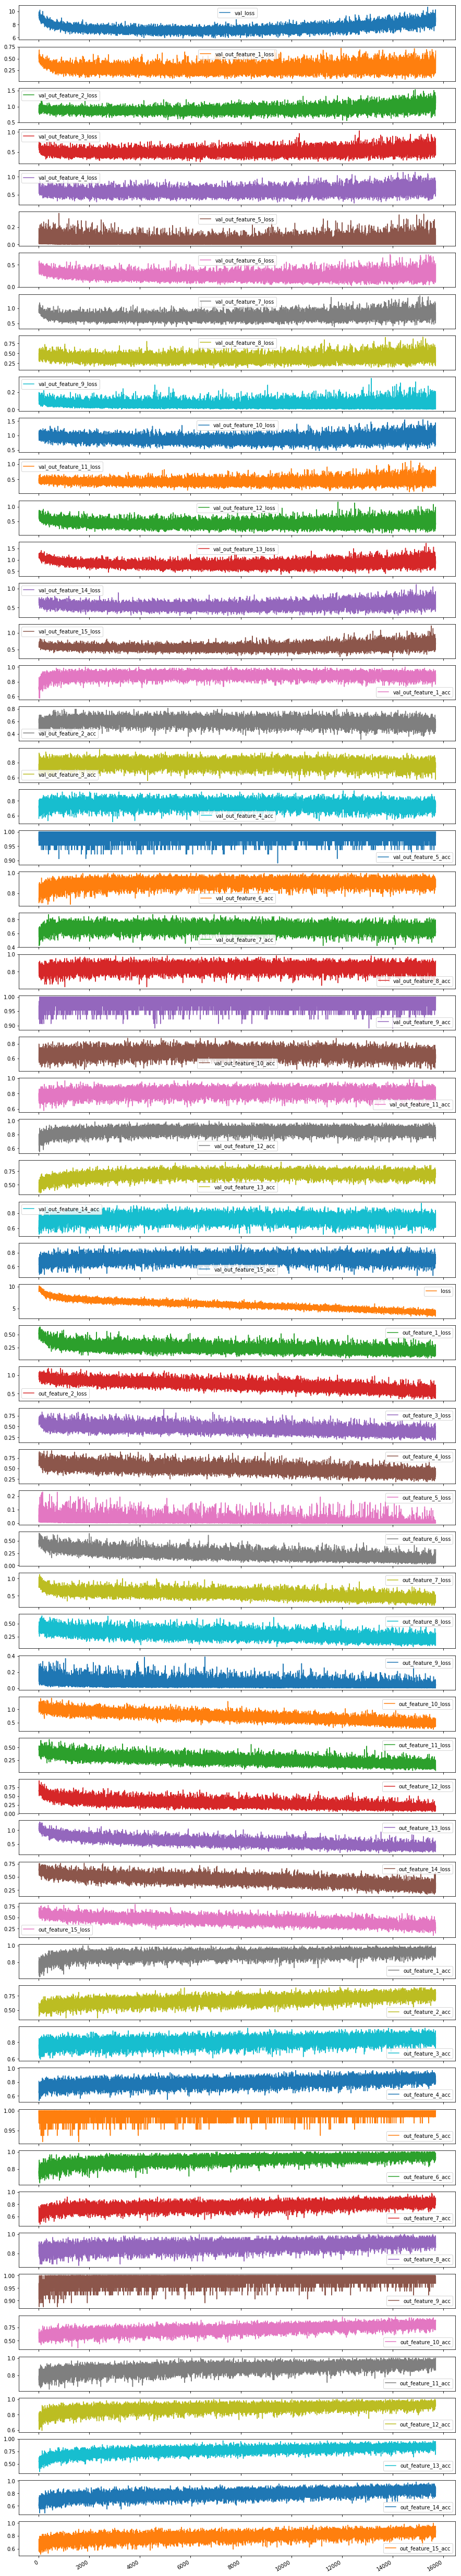

In [31]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<5.93]

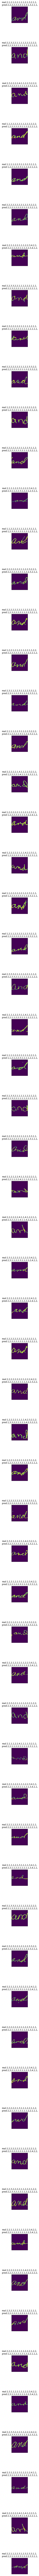

In [29]:
# human_features.load_weights('human_features_weights_v2.h5')
human_features.load_weights('weights/15-Multitask-TrainableEncoder-unseen_v2.h5')
vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
#     print(i, '\nPredicted:')
    
    real=''
    for f in range(15):
#         print(vo[i][f])
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
#     print(f_probs)
    pred=''
    for prob in f_probs:
#         print(prob)
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)
#     print('\n----------')
#     print('True:')
#     for op in o:
#         print(np.argmax(op[i]),end=',')
        
#     print('\n++++++',i,'++++++')

In [32]:
# print(df_hist.columns)
total = 0
for i in range(1,16):
    print(df_hist.iloc[5699]['val_out_feature_{0}_acc'.format(i)].max())
    total+=df_hist.iloc[5699]['val_out_feature_{0}_acc'.format(i)]
print('total_acc:',total/15)
# print(np.mean([df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max()]))
# df_hist[df_hist['val_acc']>10.2]

0.9375
0.734375
0.75
0.796875
1.0
0.953125
0.796875
0.875
1.0
0.78125
0.828125
0.890625
0.859375
0.8125
0.6875
total_acc: 0.846875


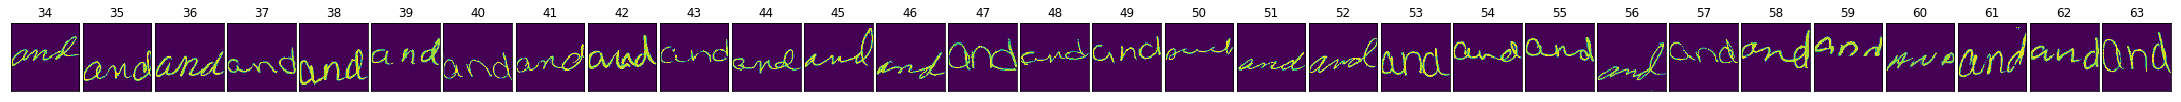

In [33]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(inputs[64-30:64][i].reshape((64,64)))
    ax.set_title(i+34)

In [34]:
# plt.imshow(inputs[10].reshape((64,64)))
# plt.subplots_adjust(hspace = 0.1)
# for i in range(1,9):
#     visualize_model = Model(human_features.input, human_features.get_layer('dense_layer_'+str(i)).output)
#     vis_out = visualize_model.predict(np.expand_dims(inputs[10],0))[0]
#     vis_out = np.rollaxis(a=vis_out, start=0, axis=2)
#     f,ax = plt.subplots(8,8)
#     f.subplots_adjust(hspace = .00, wspace=.02, top=0.95)
#     f.set_size_inches(15,15)
#     f.suptitle('dense_layer_'+str(i), fontsize=15)
# #     f.subplots_adjust(hspace = 0.1)
# #     plt.title('dense_layer_'+str(i))
#     print(vis_out.shape)
#     for r in range(8):
#         for c in range (8):
#             ax[r,c].imshow(vis_out[c+r*8])
#             ax[r,c].axis('off')
# #     break

In [35]:
csv_data.var()

pen_pressure      0.241190
letter_spacing    0.481638
size              0.475689
dimension         0.464579
is_lowercase      0.014808
is_continuous     0.222378
slantness         0.866958
tilt              0.152430
entry_stroke_a    0.053592
staff_of_a        0.862689
formation_n       0.176950
staff_of_d        0.409782
exit_stroke_d     1.054210
word_formation    0.245240
constancy         0.239313
dtype: float64

# Evaluation

In [60]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from tqdm import tqdm_notebook

In [67]:
pred_flat = []
for i in range(1,len(feature_lengths)+1):
    pred_flat.append(human_features.get_layer('dense_layer_'+str(i)).output)
human_features_eval = Model(inputs=human_features.input, outputs=pred_flat)
human_features_encoder = Model(human_features.input,human_features.get_layer('encoded').output)

In [90]:
test_g = datagen(len(val_images)*5,val_path,val_images, vshift = (-10,10), vis=True)
testx,testy = next(test_g)

In [98]:
feature_wise_pred_y=human_features_eval.predict(testx)
latent_pred_y=human_features_encoder.predict(testx)

In [99]:
feature_wise_pred_y=np.array(feature_wise_pred_y)
latent_pred_y=np.array(latent_pred_y).reshape((-1,512))

In [100]:
latent_pred_y.shape,feature_wise_pred_y.shape

((4440, 512), (15, 4440, 128))

In [105]:
testy[0].shape,testy[1].shape

((4440,), (4440,))

In [113]:
ids = testy[0].reshape(-1,1)
imagenames = testy[1].reshape(-1,1)
data=[]
for i in range(len(testx)):
    data.append([ids[i][0],imagenames[i][0],latent_pred_y[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.head(10)

,index,identity,imagename,latent
0,2617,1451,1451a_num3.png,"[0.0, 2.2770474, 0.4402785, 1.4622205, 0.0, 1...."
1,2316,1451,1451a_num2.png,"[0.0, 2.4896894, 0.0, 0.34604335, 0.48418197, ..."
2,1908,1451,1451c_num1.png,"[0.0, 2.7980387, 0.0, 0.69208854, 0.0, 0.73454..."
3,478,1451,1451b_num2.png,"[0.0, 3.5941293, 0.6528752, 0.23121236, 0.0, 2..."
4,4311,1451,1451b_num3.png,"[0.0, 3.2391636, 0.898104, 0.85949767, 0.0, 0...."
5,3229,1451,1451c_num2.png,"[0.0, 1.7424643, 0.26732466, 0.21443743, 0.0, ..."
6,3510,1451,1451c_num6.png,"[0.0, 3.57581, 0.0, 0.0, 0.98504514, 0.0, 0.0,..."
7,2397,1451,1451c_num6.png,"[0.0, 3.339717, 0.0, 0.0, 0.34077832, 0.0, 0.0..."
8,1755,1451,1451b_num3.png,"[0.0, 2.9029396, 0.63839984, 0.9862033, 0.0, 0..."
9,4124,1451,1451a_num2.png,"[0.0, 2.6058834, 0.0, 0.3195687, 0.0, 0.0, 0.0..."


In [114]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [148]:
for i in range(2,10):
    cos_thresh = i/10.0
    print('cos_thresh:',cos_thresh)

cos_thresh: 0.2
cos_thresh: 0.3
cos_thresh: 0.4
cos_thresh: 0.5
cos_thresh: 0.6
cos_thresh: 0.7
cos_thresh: 0.8
cos_thresh: 0.9


In [187]:
# recalls = []
# precisions = []
# threshs = []
# for i in range(2,10):

queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.8
# print('---------cos_thresh:',cos_thresh,'-----------')
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 10
prev_query = ''
prev_given = ''
given_count = 0
# threshs.append(cos_thresh)
# total = cos_dist_out.shape[0]
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        elif int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        elif int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        elif int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        
        prev_query = queried_idx
#         c_counter += 1
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
#     df_cos_dist_out.head()
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
print(tps,fps,tns,fns)
precision = tps/(fps+tps)
recall = tps/(tps+fns)
# recalls.append(recall)
# precisions.append(precision)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

KeyboardInterrupt: 

Text(0.5, 1.0, 'Chart to chose Threshold Value -  XAI')

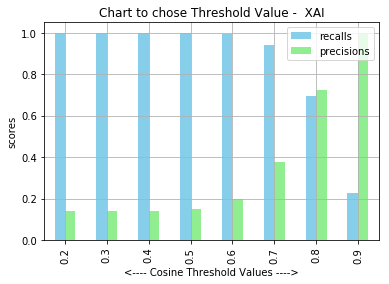

In [183]:
thresh_df = pd.DataFrame()
thresh_df['recalls']=recalls
thresh_df['precisions']=precisions
thresh_df['thresholds'] = threshs
ax=thresh_df[['recalls','precisions']].plot(kind='bar',color=['skyblue','lightgreen'],grid=True)
ax.set_xticklabels(list(thresh_df['thresholds']))
ax.set_xlabel("<---- Cosine Threshold Values ---->")
ax.set_ylabel("scores")
ax.set_title('Chart to chose Threshold Value -  XAI')
# counter=-1
# for p in ax.patches:
#     print(p)
#     counter+=1
#     ax.annotate(str(p.get_height()), (counter*0.99,0))

In [186]:
"152410 1063712 18431920 65558 \n \
precision: 0.1253245973676983 \n \
recall: 0.699231079791529 \n \
f1: 0.21255290811594807 \n \
Intra Writer Accuracy (Type 1): 0.70824986574721 \n \
Inter Writer Accuracy (Type 2):: 0.934984984984985 \n \
acc: 0.9427161959256553"

'152410 1063712 18431920 65558 \n precision: 0.1253245973676983 \n recall: 0.699231079791529 \n f1: 0.21255290811594807 \n Intra Writer Accuracy (Type 1): 0.70824986574721 \n Inter Writer Accuracy (Type 2):: 0.934984984984985 \n acc: 0.9427161959256553'

In [61]:
l = pred_y[:,0,:]
r = pred_y[:,1,:]

In [45]:
# df_feat_sim_score.style.bar(subset=['feature similarity score'], color='lightblue', align='mid')

In [47]:
for i in range(len(test_x[:2])):
    for f in range(15):
        print(np.argmax(class_preds[f][i]),end=',')
    print('')

1,1,0,0,1,1,0,0,0,1,1,2,3,0,1,
0,1,1,0,1,1,2,1,0,0,0,2,1,0,0,


In [188]:
# df_cos_dist_out.to_csv('results-DL_AE_Maxpool_1x1x512_Shuffled.csv')
# left_image = '0103b_num1.png'
# right_image = '0012c_num3.png' #0 similarity
left_image = '0124a_num5.png'
right_image = '0049a_num1.png' #0 similarity

test_im_normal = (255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/'+left_image,0))/255.0
test_im_shifted = (255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/'+right_image,0))/255.0
py1 = human_features_encoder.predict(test_im_normal.reshape((1,64,64,1)))
py2 = human_features_encoder.predict(test_im_shifted.reshape((1,64,64,1)))
l = np.array(human_features_eval.predict(test_im_normal.reshape((1,64,64,1))))
r = np.array(human_features_eval.predict(test_im_shifted.reshape((1,64,64,1))))
l = l.reshape(15,-1)
r = r.reshape(15,-1)
print(py1[py1==0].shape,py2[py2==0].shape)
py1 = py1.reshape((-1,512))
py2 = py2.reshape((-1,512))
print(py1.shape,py2.shape)

cosine_similarity(py1,py2), cosine_distances(py1,py2), euclidean_distances(py1,py2)

(213,) (227,)
(1, 512) (1, 512)


(array([[0.7902963]], dtype=float32),
 array([[0.20970368]], dtype=float32),
 array([[22.991655]], dtype=float32))

Text(0.5, 1.0, '0049a_num1.png')

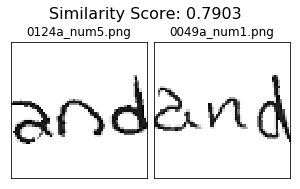

In [189]:


# print(test_im_normal.max())
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
f.suptitle('Similarity Score: '+str(np.round(cosine_similarity(py1,py2)[0][0],4)), fontsize=16)
ax[0].imshow(255.0-test_im_normal.reshape((64,64)),cmap="gray")
ax[0].axis('on')
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].imshow(255.0-test_im_shifted.reshape((64,64)),cmap="gray")
ax[1].axis('on')
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
ax[0].set_title(left_image)
ax[1].set_title(right_image)

0.8325701395670573

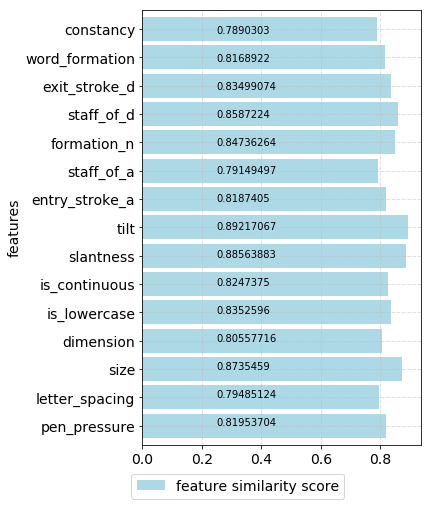

In [190]:
features = csv_data.keys()[1:]
feature_similarity_score=cosine_similarity(l,r).diagonal()
df_feat_sim_score = pd.DataFrame(columns=['features','feature similarity score'])
df_feat_sim_score['features']=features
df_feat_sim_score['feature similarity score']=feature_similarity_score
ax = df_feat_sim_score.plot.barh(width=0.85
                                 , rot=0
                                 , x='features'
                                 , color='lightblue'
                                 , fontsize=14
                                 , figsize=(5,8)
                                 , grid=True)
df_feat_sim_score['feature similarity score'].mean()

ax.legend(bbox_to_anchor=(0.75,-0.05)
          , fontsize=14)
ax.grid(color='#bebebe'
        , linestyle='-.'
        , linewidth=0.5)
plt.ylabel('features',fontsize=14)
counter=-1
for p in ax.patches:
    counter+=1
    ax.annotate(str(p.get_width()), (0.25, counter*0.99))
feature_similarity_score.sum()/15.0

(15, 1, 128)